In [179]:
import numpy as np
import math
import ast
import matplotlib.pyplot as plt
# from Bio.SubsMat import MatrixInfo as matlist
import keras
from keras.layers import Dense, Embedding, Dropout, LSTM, Conv2D, Input, GRU
from keras.layers import Conv1D, MaxPooling1D, MaxPooling2D, Flatten, ZeroPadding1D
from keras.layers import SimpleRNN, Bidirectional, concatenate
from keras.models import Model
from keras import initializers
from scipy.stats import kendalltau, mode, spearmanr
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, roc_auc_score
import random
from sklearn.linear_model import RidgeCV, LassoCV, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
import os
from sklearn.metrics.pairwise import cosine_similarity
from keras.optimizers import Adam
from IPython.display import clear_output
clear_output()

In [2]:
cd ..

/Users/zswitten/coronavirus


In [8]:
cov_gexp_profiles = pd.read_csv('data/host_gexp.csv')

In [9]:
cov_gexp_profiles = cov_gexp_profiles.drop(['rid'],axis = 1)

In [10]:
interactome = pd.read_csv('data/nCoV_host_interactome_entrez_ids.csv')

In [11]:
rids = pd.read_csv('data/level5_1000.csv').rid

In [61]:
interactome_cov_gexp_profiles = pd.read_csv('data/host_gexp.csv')
gene_in_interactome = interactome_cov_gexp_profiles['rid'].isin(interactome.GENE_ID)

In [62]:
interactome_cov_gexp_profiles = interactome_cov_gexp_profiles.loc[
    gene_in_interactome
].reset_index(drop = True)

In [17]:
interactome_cov_gexp_profiles.drop(['rid'], axis = 1, inplace=True)

In [18]:
interactome_cov_gexp_profiles.head()

,GSE68820_SARS_mouse_adapted_2dpi_log2_fc,GSE47960_BAT_24hr_log2_fc,GSE47960_SARS_24hr_log2_fc,GSE17400_SARS_24_hours_log2_fc,5_GSE147507_Series5_log2_fc,GSE100504_MERS_24hr_log2_fc,GSE47961_BAT_24hr_log2_fc,GSE47961_SARS_24hr_log2_fc,GSE56677_LoCovMERS_18hr_log2_fc,7_GSE147507_Series7_log2_fc,...,GSE86529_MERS_24hr_log2_fc,GSE108594_MERS_1e4_2dpi_log2_fc,GSE108594_MERS_1e5_2dpi_log2_fc,GSE108594_MERS_1e6_2dpi_log2_fc,GSE86528_MERS_24hr_log2_fc,15_GSE147507_Series15_log2_fc,GSE100496_MERS_24hr_log2_fc,GSE100509_MERS_24hr_log2_fc,GSE79458_MERS_24hr_log2_fc,16_GSE147507_Series16_log2_fc
0,-0.045070,-0.041735,-0.063861,-0.000323,0.119436,-0.070505,0.163924,-0.047153,-0.549065,-0.192093,...,-0.396865,-0.376939,-0.332280,-0.204117,-0.208788,1.287908,0.092821,-0.612733,-0.682893,-0.441409
1,-0.049164,-0.128339,-0.215626,0.010905,0.623270,-0.390893,-0.168798,-0.179763,-0.119630,0.464810,...,0.483670,0.009795,0.085761,0.080928,0.062165,-0.475416,-0.408972,0.841743,-0.041912,0.732235
2,0.973143,0.427588,0.518861,-0.019383,-0.488650,0.294212,-0.120544,-0.008071,-0.431039,1.667124,...,4.704538,0.468390,0.490625,0.385854,0.331905,-2.950339,0.300100,5.105798,1.043123,-0.235678
3,-0.268601,-0.067821,-0.101915,-0.047267,-0.106398,-0.174793,-0.024302,-0.013692,-0.243777,-0.203431,...,-0.052917,-0.149894,-0.257960,-0.259384,0.063495,0.180520,0.259406,-0.578849,0.297469,-0.161617
4,-0.098015,0.044136,0.183521,-0.179133,0.862686,0.246115,0.166479,0.045842,-0.730480,0.703781,...,-0.270729,0.104893,0.113681,0.047695,-0.173023,-2.973171,-0.108585,0.441159,-0.460739,0.674678


In [21]:
cols = [
    c for c in interactome_cov_gexp_profiles.columns
    if 'GSE147507' in c and not '15' in c
]

In [22]:
cov2_gexp = interactome_cov_gexp_profiles[cols]

In [24]:
test_df = pd.read_pickle('data/test_df.pkl')

In [25]:
train_df = pd.read_pickle('data/train_df.pkl')

In [26]:
val_df = pd.read_pickle('data/valid_df.pkl')

In [32]:
test_pert_df = pd.read_csv('data/test_full.csv').drop_duplicates().reset_index(drop = True)
train_pert_df = pd.read_csv('data/train_full.csv').drop_duplicates().reset_index(drop = True)
val_pert_df = pd.read_csv('data/val_full.csv').drop_duplicates().reset_index(drop = True)

In [41]:
x_train = np.array(train_df.gexp)
x_train = np.array([np.array(x) for x in x_train])
y_train = train_df.Inh_index
vcs = train_df.Inh_index.value_counts()
train_weights = [1.0/vcs[inh] for inh in train_df.Inh_index]

In [42]:
x_val = np.array(val_df.gexp)
x_val = np.array([np.array(x) for x in x_val])
y_val = val_df.Inh_index
vcs = val_df.Inh_index.value_counts()
val_weights = [1.0/vcs[inh] for inh in val_df.Inh_index]

In [43]:
x_test = np.array(test_df.gexp)
x_test = np.array([np.array(x) for x in x_test])
y_test = test_df.Inh_index
vcs = test_df.Inh_index.value_counts()
test_weights = [1.0/vcs[inh] for inh in test_df.Inh_index]

In [44]:
all_cell_ids = list(train_df.cell_id) + list(val_df.cell_id) + list(test_df.cell_id)
all_one_hot = pd.get_dummies(all_cell_ids)
x_train_dose = np.log1p(train_df.pert_dose)
x_val_dose = np.log1p(val_df.pert_dose)
x_test_dose = np.log1p(test_df.pert_dose)

In [45]:
x_train_cell = all_one_hot[0:len(x_train)].reset_index(drop = True)
x_val_cell = all_one_hot[len(x_train):(len(x_train)+len(x_val))].reset_index(drop = True)
x_test_cell = all_one_hot[(len(x_train)+len(x_val)):].reset_index (drop = True)

In [60]:
pd.read_csv('data/level5_1000.csv').head(10)

,rid,CPC005_A375_6H:BRD-A85280935-003-01-7:10,CPC005_A375_6H:BRD-A07824748-001-02-6:10,CPC004_A375_6H:BRD-K20482099-001-01-1:10,CPC005_A375_6H:BRD-K62929068-001-03-3:10,CPC005_A375_6H:BRD-K43405658-001-01-8:10,CPC004_A375_6H:BRD-K03670461-001-02-0:10,CPC004_A375_6H:BRD-K36737713-001-01-6:10,CPC005_A375_6H:BRD-K51223576-001-01-3:10,CPC004_A375_6H:BRD-A14966924-001-03-0:10,...,CPC005_A375_24H:BRD-A59303141-001-03-9:10,CPC005_A375_24H:BRD-K54665485-001-04-6:10,CPC005_A375_24H:BRD-A54236247-003-03-5:10,CPC005_A375_24H:BRD-K10098805-001-02-0:10,CPC005_A375_24H:BRD-K13725475-001-02-4:10,CPC005_A375_24H:BRD-A08003242-001-02-7:10,CPC005_A375_24H:BRD-K43796186-001-01-1:10,CPC005_A375_24H:BRD-K83063356-003-01-7:10,CPC005_A375_24H:BRD-K86600316-003-01-2:10,CPC005_A375_24H:BRD-A92585442-237-01-0:10
0,5720,0.773769,-0.645586,-5.449666,0.193408,1.006298,-5.388713,-1.000240,0.490110,0.063297,...,0.160586,-0.193009,0.247968,0.384757,0.352685,-0.233490,0.281433,1.141963,-0.302364,1.025050
1,466,-0.818468,-0.810749,2.393775,-0.582243,0.455536,1.867731,-1.106092,0.595174,-0.962553,...,0.161364,-0.244689,0.559568,0.592947,-1.140376,-2.413500,-1.134386,0.623217,-0.170404,0.265432
2,6009,0.189572,0.459060,1.279790,-0.178977,0.631738,0.281383,-0.422545,-0.224163,0.521552,...,-0.663482,-0.235831,0.684576,1.720635,-0.254450,-0.414349,-0.796767,0.418341,0.870858,-0.539486
3,2309,-0.146031,-0.224676,2.167868,-1.182025,-0.936414,1.378175,0.406279,-0.244783,0.182361,...,0.552385,0.218920,-0.601392,-0.404516,0.662811,1.789149,0.664427,1.452139,-0.774794,-0.752421
4,387,-0.654002,-0.335681,2.333199,-1.012651,-1.213203,1.290522,-0.218671,-0.124029,0.572183,...,-0.373290,1.054628,0.458266,0.077265,0.079647,-1.665797,-0.323780,0.285577,0.879944,0.504271
5,3553,0.206183,2.804548,1.649395,1.753655,1.662564,-0.062530,-0.010684,0.870721,-0.041685,...,-0.847930,0.723632,-0.237169,-0.850291,0.410342,-0.096936,1.801064,0.992494,0.278117,-0.254486
6,427,0.626013,-0.125799,2.004065,-0.988824,-0.239190,1.216093,-0.161298,0.718059,-0.286217,...,0.626145,0.540184,0.432911,-0.159552,-0.072022,0.545687,0.557036,0.152161,-0.512180,-0.347042
7,5898,-0.260590,0.304977,0.466132,-0.217892,0.079852,1.361654,0.485683,0.261966,-0.316737,...,-0.107684,-0.119725,-0.285170,0.400834,0.977183,5.724462,-0.420209,-0.758124,0.522106,0.512390
8,23365,0.369380,-0.895473,2.341779,0.807503,-0.992458,1.287970,-0.163090,-0.335684,0.014743,...,1.610174,4.179843,-0.821168,-0.043191,-0.523588,-0.694197,-1.817108,-0.559325,-0.246299,-0.204829
9,6657,0.328593,3.438638,2.535294,-1.357967,0.676782,-0.109262,-0.987153,0.925768,1.000890,...,-0.591321,-0.487211,-0.239505,-0.370171,1.146883,-5.673955,-0.624227,1.224008,-0.294840,-0.378230


In [81]:
# import csv
x_test_for_cos = []
for j, x in enumerate(x_test):
    x_test_for_cos.append(x[gene_in_interactome.values])
    
x_val_for_cos = []
for j, x in enumerate(x_val):
    x_val_for_cos.append(x[gene_in_interactome.values])
    
x_train_for_cos = []
for j, x in enumerate(x_train):
    x_train_for_cos.append(x[gene_in_interactome.values])


In [83]:
# x_test_for_cos = [[float(val) for val in inner] for inner in x_test_for_cos]
# x_train_for_cos = [[float(val) for val in inner] for inner in x_train_for_cos]
# x_val_for_cos = [[float(val) for val in inner] for inner in x_val_for_cos]

In [102]:
def cos_similarity_with_na(list1, list2, use_abs = False):
    dot = 0
    ss1 = 0
    ss2 = 0
    for i in range(len(list1)):
        val1 = list1[i]
        val2 = list2[i]
        if use_abs:
            val1 = abs(val1)
            val2 = abs(val2)
        if not (np.isnan(val1) or np.isnan(val2)):
            ss1 += val1 * val1
            ss2 += val2 * val2
            dot += val1 * val2
    return dot/(np.sqrt(ss1)*np.sqrt(ss2))

In [122]:
norm_cov2_gexp = (cov2_gexp - cov2_gexp.mean()) / cov2_gexp.std()

In [98]:
def get_cosines(x_dset, cov_dset, intervals = 2000, use_abs = False):
    to_return = [[] for _ in x_dset]
    for i in range(len(x_dset)):
        to_return[i] = [
            cos_similarity_with_na(x_dset[i], cov_dset[name], use_abs = use_abs) for name in list(cov_dset.columns)
        ]
        if i%intervals == 5:
            print(i)
    return to_return

def get_normalized_2d_list(dset):
    stds = [np.std(xvec) for xvec in dset]
    means = [np.mean(xvec) for xvec in dset]
    to_return = []
    for i, xvec in enumerate(dset):
        to_return.append([(x-means[i])/stds[i] for x in xvec])
    return to_return

In [100]:
norm_x_test_for_cos = get_normalized_2d_list(x_test_for_cos)
norm_x_train_for_cos = get_normalized_2d_list(x_train_for_cos)
norm_x_val_for_cos = get_normalized_2d_list(x_val_for_cos)

In [103]:
x_test_cosine = get_cosines(norm_x_test_for_cos, norm_cov2_gexp)
x_val_cosine = get_cosines(norm_x_val_for_cos, norm_cov2_gexp)
x_train_cosine = get_cosines(norm_x_train_for_cos, norm_cov2_gexp)

5
2005
4005
5
2005
4005
6005
5
2005
4005
6005
8005
10005
12005
14005
16005
18005


In [104]:
# x_test_cosine_abs = get_cosines(norm_x_test_for_cos, norm_cov2_gexp, use_abs = True)
# x_val_cosine_abs = get_cosines(norm_x_val_for_cos, norm_cov2_gexp, use_abs = True)
# x_train_cosine_abs = get_cosines(norm_x_train_for_cos, norm_cov2_gexp, use_abs = True)

In [129]:
norm_x_test_for_cos = np.array(norm_x_test_for_cos)
norm_cov2_gexp = np.array(norm_cov2_gexp).transpose()

In [130]:
(norm_x_test_for_cos[0] - norm_cov2_gexp[0]).shape

(278,)

In [131]:
norm_x_test_for_cos.shape

(5581, 278)

In [132]:
def get_comp_to_cov(x_matrix, cov_df):
    to_return = [[] for _ in x_matrix]
    for i, gexp_profile in enumerate(x_matrix):
        for gexp_profile_ in cov_df:
            to_return[i].append(
                gexp_profile - gexp_profile_
            )

    return to_return

In [139]:
x_test_comp_to_cov_norm = get_comp_to_cov(norm_x_test_for_cos, norm_cov2_gexp)
x_val_comp_to_cov_norm = get_comp_to_cov(norm_x_val_for_cos, norm_cov2_gexp)
x_train_comp_to_cov_norm = get_comp_to_cov(norm_x_train_for_cos, norm_cov2_gexp)

In [138]:
x_val_comp_to_cov_norm = get_comp_to_cov(norm_x_val_for_cos, norm_cov2_gexp)
x_train_comp_to_cov_norm = get_comp_to_cov(norm_x_train_for_cos, norm_cov2_gexp)

In [142]:
def nan_to_zero(list_with_nans):
    for i, xvec in enumerate(list_with_nans):
        for j, xvec2 in enumerate(xvec):
            for k, x in enumerate(xvec2):
                if np.isnan(x):
                    list_with_nans[i][j][k] = 0

In [143]:
nan_to_zero(x_test_comp_to_cov_norm)

In [144]:
nan_to_zero(x_val_comp_to_cov_norm)

In [145]:
nan_to_zero(x_train_comp_to_cov_norm)

In [147]:
np.std(x_train_comp_to_cov_norm[8:20])

1.3826673677560788

In [148]:
def dense_regression_model(n_big_layers=2,layer_size=100,dropout=0.1,input_dim=12328):
    model = keras.models.Sequential()
    model.add(Dense(layer_size,activation='relu',input_dim=input_dim))
    model.add(Dropout(dropout))
    for i in range(n_big_layers-1):
        model.add(Dense(layer_size,activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def dense_model_api():
    gexp_input = Input(shape = (12328,))
    gexp_layer = Dense(100, activation = 'relu')(gexp_input)
    dropout_layer = Dropout(0.1)(gexp_layer)
    gexp_layer = Dense(100, activation = 'relu')(dropout_layer)
    dropout_layer = Dropout(0.1)(gexp_layer)
    gexp_layer = Dense(20, activation = 'relu')(dropout_layer)
    output_layer = Dense(1)(gexp_layer)
    gexp_model = Model(inputs = gexp_input, outputs = output_layer)
    gexp_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return gexp_model


def dense_regression_model_with_cos_similarity_and_cell_id(dropout = 0.1, gexp_input_dim = 12328, cosine_input_dim = 31,
                                             n_cell_lines = 70, dose_layers = 1, gexp_layer_size = 100, concat_layer_size = 100,
                                            gexp_layers = 1, post_concat_layers = 2):
#     Define inputs
    cosine_input = Input(shape = (cosine_input_dim,))
    gexp_input = Input(shape = (gexp_input_dim,))
    cell_input = Input(shape = (n_cell_lines,))
    
#     First branch on formulation input
    cosine_layer = Dense(cosine_input_dim)(cosine_input)
    if cosine_layers > 1:
        for i in range(cosine_layers-1):
            cosine_layer = Dense(cosine_input_dim, activation = 'relu')(cosine_layer)
#     dose_model = Model(inputs = dose_input, outputs = dose_layer)
    
#     Second branch on structure input
    gexp_layer = Dense(gexp_layer_size)(gexp_input)
    if gexp_layers > 1:
        for i in range(gexp_layers-1):
            gexp_layer = Dense(gexp_layer_size, activation = 'relu')(gexp_layer)
#     gexp_model = Model(inputs = gexp_input, outputs = gexp_layer)

# Third branch on cell ID input
    cell_layer = Dense(n_cell_lines)(cell_input)
    
#     Concatenate and put on the finishing touches
    combined = concatenate([cosine_layer, gexp_layer, cell_layer])
    dropout_layer = Dropout(dropout)(combined)
    combined_layer = Dense(concat_layer_size, activation = 'relu')(dropout_layer)
    if post_concat_layers > 1:
        for i in range(post_concat_layers-1):
            dropout_layer = Dropout(dropout)(combined_layer)
            combined_layer = Dense(20, activation = 'relu')(dropout_layer)
    final_output = Dense(1)(combined_layer)
    model = Model(inputs = [gexp_input, cosine_input, cell_input], outputs = final_output)
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model


def dense_regression_model_with_dose_and_cell_id(dropout = 0.1, gexp_input_dim = 12328, dose_input_dim = 1,
                                             n_cell_lines = 70, dose_layers = 1, gexp_layer_size = 100, concat_layer_size = 100,
                                            gexp_layers = 1, post_concat_layers = 2):
#     Define inputs
    dose_input = Input(shape = (dose_input_dim,))
    gexp_input = Input(shape = (gexp_input_dim,))
    cell_input = Input(shape = (n_cell_lines,))
    
#     First branch on formulation input
    dose_layer = Dense(dose_input_dim)(dose_input)
    if dose_layers > 1:
        for i in range(dose_layers-1):
            dose_layer = Dense(dose_input_dim, activation = 'relu')(dose_layer)
#     dose_model = Model(inputs = dose_input, outputs = dose_layer)
    
#     Second branch on structure input
    gexp_layer = Dense(gexp_layer_size)(gexp_input)
    if gexp_layers > 1:
        for i in range(gexp_layers-1):
            gexp_layer = Dense(gexp_layer_size, activation = 'relu')(gexp_layer)
#     gexp_model = Model(inputs = gexp_input, outputs = gexp_layer)

# Third branch on cell ID input
    cell_layer = Dense(n_cell_lines)(cell_input)
    
#     Concatenate and put on the finishing touches
    combined = concatenate([gexp_layer, cell_layer])
    dropout_layer = Dropout(dropout)(combined)
    combined_layer = Dense(concat_layer_size, activation = 'relu')(dropout_layer)
    if post_concat_layers > 1:
        for i in range(post_concat_layers-1):
            dropout_layer = Dropout(dropout)(combined_layer)
            combined_layer = Dense(20, activation = 'relu')(dropout_layer)
    final_output = Dense(1)(combined_layer)
    model = Model(inputs = [gexp_input, dose_input, cell_input], outputs = final_output)
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

def dense_regression_model_with_dose(dropout = 0.1, gexp_input_dim = 12328, dose_input_dim = 1,
                                             dose_layers = 1, gexp_layer_size = 100, concat_layer_size = 100,
                                            gexp_layers = 1, post_concat_layers = 2):
#     Define inputs
    dose_input = Input(shape = (dose_input_dim,))
    gexp_input = Input(shape = (gexp_input_dim,))
    
#     First branch on formulation input
    dose_layer = Dense(dose_input_dim)(dose_input)
    if dose_layers > 1:
        for i in range(dose_layers-1):
            dose_layer = Dense(dose_input_dim, activation = 'relu')(dose_layer)
#     dose_model = Model(inputs = dose_input, outputs = dose_layer)
    
#     Second branch on structure input
    gexp_layer = Dense(gexp_layer_size)(gexp_input)
    if gexp_layers > 1:
        for i in range(gexp_layers-1):
            gexp_layer = Dense(gexp_layer_size, activation = 'relu')(gexp_layer)
#     gexp_model = Model(inputs = gexp_input, outputs = gexp_layer)
    
#     Concatenate and put on the finishing touches
    combined = concatenate([dose_layer, gexp_layer])
    dropout_layer = Dropout(dropout)(combined)
    combined_layer = Dense(concat_layer_size, activation = 'relu')(dropout_layer)
    if post_concat_layers > 1:
        for i in range(post_concat_layers-1):
            dropout_layer = Dropout(dropout)(combined_layer)
            combined_layer = Dense(20, activation = 'relu')(dropout_layer)
    final_output = Dense(1)(combined_layer)
    model = Model(inputs = [gexp_input, dose_input], outputs = final_output)
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

def all_dense_model(dropout = 0.4, gexp_input_dim = 12328, cos_input_dim = 6, cos_layer_size = 6, dose_input_dim = 1,
                         cell_input_dim = 70, gexp_comp_input_dim_1 = 6, gexp_comp_input_dim_2 = 278,
                    dose_layers = 1, cell_layers = 1, gexp_layers = 1, cos_layers = 1, gexp_comp_layers = 1,
                          post_concat_layers = 2, gexp_layer_size = 100, cell_layer_size = 30,
                    concat_layer_size = 100, gexp_comp_layer_size = 100, gexp_comp_filters = 100,
                         use_gexp = True, use_cos = False, use_cell = True, use_dose = False, use_gexp_comp = True):
    layers_to_merge = []
    input_layers = []
#     Gene expression branch
    if use_gexp:
        gexp_input = Input(shape = (gexp_input_dim,))
        gexp_layer = Dense(gexp_layer_size)(gexp_input)
        if gexp_layers > 1:
            for i in range(gexp_layers-1):
                gexp_layer = Dense(gexp_layer_size, activation = 'swish')(gexp_layer)
        layers_to_merge.append(gexp_layer)
        input_layers.append(gexp_input)
# Cosine similarity branch
    if use_cos:
        cosine_input = Input(shape = (cos_input_dim,))
        cosine_layer = Dense(cos_layer_size)(cosine_input)
        if cos_layers > 1:
            for i in range(cos_layers-1):
                cosine_layer = Dense(cos_layer_size, activation = 'swish')(cosine_layer)
        layers_to_merge.append(cosine_layer)
        input_layers.append(cosine_input)
# Gene expression comparison branch
    if use_gexp_comp:
        gexp_comp_input = Input(shape = (gexp_comp_input_dim_1,gexp_comp_input_dim_2,))
#         conv_layer = Conv1D(gexp_comp_filters, kernel_size = gexp_comp_input_dim_2,
#                             padding = 'valid', data_format = 'channels_first')(gexp_comp_input)
        flatten_layer = Flatten()(gexp_comp_input)
        gexp_comp_layer = Dense(gexp_comp_layer_size)(flatten_layer)
        if gexp_comp_layers > 1:
            for i in range(gexp_comp_layers-1):
                gexp_comp_layer = Dense(gexp_comp_layer_size, activation = 'swish')(gexp_comp_layer)
        layers_to_merge.append(gexp_comp_layer)
        input_layers.append(gexp_comp_input)
# Dose branch
    if use_dose:
        dose_input = Input(shape = (dose_input_dim,))
        dose_layer = Dense(dose_layer_size)(dose_layer)
        if dose_layers > 1:
            for i in range(dose_layers-1):
                dose_layer = Dense(dose_layer_size, activation = 'swish')(dose_layer)
        layers_to_merge.append(dose_layer)
        input_layers.append(dose_input)
# Cell line branch
    if use_cell:
        cell_input = Input(shape = (cell_input_dim,))
        cell_layer = Dense(cell_layer_size)(cell_input)
        if cell_layers > 1:
            for i in range(cell_layers-1):
                cell_layer = Dense(cell_layer_size, activation = 'swish')(cell_layer)
        layers_to_merge.append(cell_layer)
        input_layers.append(cell_input)
# Merged branch
    combined = concatenate(layers_to_merge)
    dropout_layer = Dropout(dropout)(combined)
    combined_layer = Dense(concat_layer_size, activation = 'abs')(dropout_layer)
    if post_concat_layers > 1:
        for i in range(post_concat_layers-1):
            dropout_layer = Dropout(dropout)(combined_layer)
            combined_layer = Dense(concat_layer_size, activation = 'swish')(dropout_layer)
    final_output = Dense(1)(combined_layer)
    model = Model(inputs = input_layers, outputs = final_output)
#     model.compile(loss = 'mean_squared_error', optimizer = Adam(learning_rate = 0.01))
    model.compile(loss = 'mean_squared_error', optimizer ='adam')
    return model


In [149]:
def get_performance(predictions, y_vals, reference_df, good_cutoff = 4.5, active_cutoff = 1):
    all_corr, all_auc, all_n = get_performance_given_cutoff(predictions, y_vals, reference_df, 0.5, active_cutoff)
    good_corr, good_auc, good_n = get_performance_given_cutoff(predictions, y_vals, reference_df, good_cutoff, active_cutoff)
    print('Using all perturbagens from test set:')
    print('Pearson rho: ',all_corr)
    print('AUC: ',all_auc)
    print('n: ',all_n)
    print('Using only perturbagens with at least ',good_cutoff,' measurements:')
    print('Pearson rho: ',good_corr)
    print('AUC: ',good_auc)
    print('n: ',good_n)
    print('\n')
    return all_corr, all_auc, all_n, good_corr, good_auc, good_n

def get_corr_only(predictions, y_vals, reference_df, good_cutoff = 4.5):
    averaged_predictions, actual_y_vals = average_predictions_over_measurements(predictions, y_vals,
                                                                                reference_df,
                                                                                n_measurements_cutoff = good_cutoff)
    return np.corrcoef(averaged_predictions, actual_y_vals)[0][1]

def get_performance_given_cutoff(predictions, y_vals, reference_df, n_measurements_cutoff, active_cutoff):
    predictions = [pred for pred in predictions]
    y_vals = [val for val in y_vals]
#     print('Un-averaged pearson rho: ',np.corrcoef(np.array(predictions).T, y_vals)[0][1])
    tau,pval = kendalltau(predictions, y_vals)
#     print('Un-averaged kendall tau: ', tau)
#     plt.figure()
#     plt.plot(predictions, y_vals, '.')
    averaged_predictions, actual_y_vals = average_predictions_over_measurements(predictions, y_vals, reference_df,
                                                                                n_measurements_cutoff = n_measurements_cutoff)
#     print('Averaged pearson rho: ',np.corrcoef(np.array(averaged_predictions).T, actual_y_vals)[0][1])
    tau,pval = kendalltau(averaged_predictions, actual_y_vals)
#     print('Averaged kendall tau: ', tau)
    plt.figure()
    plt.plot(averaged_predictions, actual_y_vals, '.')
    actual_class = [1.0*(val>active_cutoff) for val in actual_y_vals]
#     print(actual_class)
#     print(averaged_predictions)
    fpr, tpr, thresholds = roc_curve(actual_class, averaged_predictions)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1])
#     print('AUC: ',roc_auc_score(actual_class, averaged_predictions))
    return np.corrcoef(np.array(averaged_predictions).T, actual_y_vals)[0][1], roc_auc_score(actual_class, averaged_predictions), len(actual_y_vals)
    

def average_predictions_over_measurements(predictions, y_vals, reference_df, n_measurements_cutoff = 0.5):
    sorted_predictions = [[] for i in range(len(reference_df))]
    averaged_predictions = []
#     actual_y_vals = reference_df.Inh_index
    actual_y_vals = []
    for i, val in enumerate(y_vals):
        index = reference_df.index[reference_df.Inh_index == val].tolist()[0]
#         if len(reference_df.index[reference_df.Inh_index == val].tolist())>1:
#             print('ERROR with val ',val)
#             for idx in reference_df.index[reference_df.Inh_index == val].tolist():
#                 print(idx)
#             return 0
        sorted_predictions[index].append(predictions[i])
    for i, pred_list in enumerate(sorted_predictions):
        if len(pred_list)>n_measurements_cutoff:
            averaged_predictions.append(np.mean(pred_list))
            actual_y_vals.append(reference_df.Inh_index[i])
#     averaged_predictions = [np.mean(sort) for sort in sorted_predictions]
#     print('SLKFJASL;KDFJSADL;KFJ\n\n')
#     print(len(averaged_predictions))
#     print(len(actual_y_vals))
#     print('\n\n\n')
    return averaged_predictions, actual_y_vals




In [150]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
def absol(x):
    return abs(x)
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})
get_custom_objects().update({'abs': Activation(absol)})

In [151]:
# all_ref_df = pd.concat([train_pert_df, val_pert_df, test_pert_df], ignore_index = True)

In [153]:
all_ref_df = pd.concat([train_df, val_df, test_df], ignore_index = True)
all_x = [np.concatenate((x_train, x_val, x_test)),
        np.concatenate((x_train_for_cos, x_val_for_cos, x_test_for_cos)),
         np.concatenate((x_train_cosine, x_val_cosine, x_test_cosine)),
         np.concatenate((x_train_cosine, x_val_cosine, x_test_cosine)),
#          np.concatenate((x_train_cosine_abs, x_val_cosine_abs, x_test_cosine_abs)),
        np.concatenate((
            x_train_comp_to_cov_norm, x_val_comp_to_cov_norm, x_test_comp_to_cov_norm)),
         np.concatenate((x_train_cell, x_val_cell, x_test_cell)),
        np.concatenate((y_train, y_val, y_test)),
        np.concatenate((train_weights, val_weights, test_weights))]
ref_pert_df = pd.concat([train_pert_df, val_pert_df, test_pert_df], ignore_index = True)


In [154]:
# def corr_metric(y_true, y_pred):
#     return np.corrcoef(y_true, y_pred)[0][1]
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 100, restore_best_weights = True)

In [155]:
test_sets = [_ for i in range(5)]
cv_models = [all_dense_model(use_gexp = True, use_gexp_comp = True, use_cos = False, gexp_input_dim = 12328) for i in range(5)]

In [31]:
def rearrange_datasets(fold, all_ref_df,
                       all_xs, merge_train_and_val = False):

    new_train_df = pd.read_csv(fold + 'train_full.csv')
    new_test_df = pd.read_csv(fold + 'test_full.csv')
    new_val_df = pd.read_csv(fold + 'val_full.csv')
    new_x_trains = [[] for _ in range(len(all_xs))]
    new_x_vals = [[] for _ in range(len(all_xs))]
    new_x_tests = [[] for _ in range(len(all_xs))]

    for i, row in all_ref_df.iterrows():
        placed = False
        for j, pertid_list in enumerate(new_train_df.pert_ID):
            if row.pert_id in pertid_list and not np.isnan(new_train_df.Touret_inh_index[j]):
                for k in range(len(all_xs)):
                    new_x_trains[k].append(all_xs[k][i])
                placed = True

        if not placed:
            for j, pertid_list in enumerate(new_val_df.pert_ID):
                if row.pert_id in pertid_list and not np.isnan(new_val_df.Touret_inh_index[j]):
                    for k in range(len(all_xs)):
                        new_x_vals[k].append(all_xs[k][i])
                    placed = True

        if not placed:
            for j, pertid_list in enumerate(new_test_df.pert_ID):
                if row.pert_id in pertid_list and not np.isnan(new_test_df.Touret_inh_index[j]):
                    for k in range(len(all_xs)):
                        new_x_tests[k].append(all_xs[k][i])
                    placed = True

    if merge_train_and_val:
        all_x_trains = [new_x_trains[i]+new_x_vals[i] for i in range(len(all_xs))]
        return all_x_trains, new_x_tests
    return new_x_trains, new_x_vals, new_x_tests


In [293]:
def rearrange_datasets(fold, all_ref_df,
                       all_xs, merge_train_and_val = False):
    new_train_df = pd.read_csv(fold + 'train_full.csv')
    new_test_df = pd.read_csv(fold + 'test_full.csv')
    new_valid_df = pd.read_csv(fold + 'val_full.csv')

    new_x_trains = [[] for _ in range(len(all_xs))]
    new_x_valids = [[] for _ in range(len(all_xs))]
    new_x_tests = [[] for _ in range(len(all_xs))]

    new_train_df = new_train_df[new_train_df.Touret_inh_index.notnull()]
    new_valid_df = new_valid_df[new_valid_df.Touret_inh_index.notnull()]
    new_test_df = new_test_df[new_test_df.Touret_inh_index.notnull()]

    new_train_df['pert_ID'] = new_train_df['pert_ID'].apply(ast.literal_eval)
    train_pert_ids = new_train_df.explode('pert_ID').pert_ID.unique()
    new_valid_df['pert_ID'] = new_valid_df['pert_ID'].apply(ast.literal_eval)
    valid_pert_ids = new_valid_df.explode('pert_ID').pert_ID.unique()
    new_test_df['pert_ID'] = new_test_df['pert_ID'].apply(ast.literal_eval)
    test_pert_ids = new_test_df.explode('pert_ID').pert_ID.unique()

    all_ref_df['split'] = all_ref_df.pert_id.apply(
        lambda x: 'train' if x in train_pert_ids
                else 'valid' if x in valid_pert_ids
                else 'test' if x in test_pert_ids
                else None
    )
    for i, row in all_ref_df.iterrows():
        if row.pert_id in train_pert_ids:
            for k in range(len(all_xs)):
                new_x_trains[k].append(all_xs[k][i])

        elif row.pert_id in valid_pert_ids:
            for k in range(len(all_xs)):
                new_x_valids[k].append(all_xs[k][i])
            placed = True

        elif row.pert_id in test_pert_ids:
            for k in range(len(all_xs)):
                new_x_tests[k].append(all_xs[k][i])
            placed = True

    if merge_train_and_val:
        all_x_trains = [new_x_trains[i]+new_x_valids[i] for i in range(len(all_xs))]
        return all_x_trains, new_x_tests

    return new_x_trains, new_x_valids, new_x_tests

In [240]:
# def rearrange_datasets(fold, all_ref_df,
#                        all_xs, merge_train_and_val = False):
# all_xs = all_x
# fold = 'data/Crossval_splits/fold_0/'

# new_train_df = pd.read_csv(fold + 'train_full.csv')
# new_test_df = pd.read_csv(fold + 'test_full.csv')
# new_valid_df = pd.read_csv(fold + 'val_full.csv')
# new_x_trains = [[] for _ in range(len(all_xs))]
# new_x_valids = [[] for _ in range(len(all_xs))]
# new_x_tests = [[] for _ in range(len(all_xs))]

In [241]:
# new_train_df = new_train_df[new_train_df.Touret_inh_index.notnull()]
# new_valid_df = new_valid_df[new_valid_df.Touret_inh_index.notnull()]
# new_test_df = new_test_df[new_test_df.Touret_inh_index.notnull()]

In [242]:
# new_train_df['pert_ID'] = new_train_df['pert_ID'].apply(ast.literal_eval)
# train_pert_ids = new_train_df.explode('pert_ID').pert_ID.unique()

In [243]:
# new_valid_df['pert_ID'] = new_valid_df['pert_ID'].apply(ast.literal_eval)
# valid_pert_ids = new_valid_df.explode('pert_ID').pert_ID.unique()

In [244]:
# new_test_df['pert_ID'] = new_test_df['pert_ID'].apply(ast.literal_eval)
# test_pert_ids = new_test_df.explode('pert_ID').pert_ID.unique()

In [249]:
# all_ref_df['split'] = all_ref_df.pert_id.apply(
#     lambda x: 'train' if x in train_pert_ids else 'valid' if x in valid_pert_ids else 'test' if x in test_pert_ids else None
# )

In [268]:
# for i, row in all_ref_df.iterrows():
#     if row.pert_id in train_pert_ids:
#         for k in range(len(all_xs)):
#             new_x_trains[k].append(all_xs[k][i])

#     elif row.pert_id in valid_pert_ids:
#         for k in range(len(all_xs)):
#             new_x_valids[k].append(all_xs[k][i])
#         placed = True

#     elif row.pert_id in test_pert_ids:
#         for k in range(len(all_xs)):
#             new_x_tests[k].append(all_xs[k][i])
#         placed = True

# if merge_train_and_val:
#     all_x_trains = [new_x_trains[i]+new_x_valids[i] for i in range(len(all_xs))]
#     return all_x_trains, new_x_tests
# return new_x_trains, new_x_vals, new_x_tests

In [294]:
all_cv_trains = [_ for i in range(5)]
all_cv_valids = [_ for i in range(5)]
all_cv_tests = [_ for i in range(5)]

In [296]:
for i in range(5):
    print(i)
    split_header = 'data/Crossval_splits/fold_' + str(i) + '/'
    all_cv_trains[i], all_cv_valids[i], all_cv_tests[i] = rearrange_datasets(
        split_header, all_ref_df, all_x, merge_train_and_val=False
    )

0
1
2
3
4


In [269]:
for i in range(5):
    try:
        os.makedirs('Model_checkpoints/cov2_comp/fold_'+str(i))
    except:
        pass
    checkpoint_path = 'Model_checkpoints/cov2_comp/fold_'+str(i)+'/saved-model-{epoch:02d}.hdf5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=False,
        period = 5
    )
    
    cv_trains = all_cv_trains[i]
    cv_vals = all_cv_vals[i]
    cv_tests = all_cv_tests[i]
    cv_models[i].fit([
        np.array(cv_trains[0]), np.array(cv_trains[4]), np.array(cv_trains[5])], cv_trains[6],
                     batch_size = 64, epochs = 150,
                     sample_weight = np.array(cv_trains[7]),
                     shuffle = True, callbacks = [model_checkpoint_callback])

Epoch 1/150
21364/21364 [==============================] - 6s 282us/step - loss: 1.0572
Epoch 2/150
21364/21364 [==============================] - 5s 223us/step - loss: 0.2795
Epoch 3/150
21364/21364 [==============================] - 5s 225us/step - loss: 0.1933
Epoch 4/150
21364/21364 [==============================] - 5s 222us/step - loss: 0.0766
Epoch 5/150
21364/21364 [==============================] - 5s 234us/step - loss: 0.0414
Epoch 6/150
21364/21364 [==============================] - 6s 273us/step - loss: 0.0322
Epoch 7/150
21364/21364 [==============================] - 5s 240us/step - loss: 0.0186
Epoch 8/150
21364/21364 [==============================] - 5s 239us/step - loss: 0.0136
Epoch 9/150
21364/21364 [==============================] - 5s 238us/step - loss: 0.0119
Epoch 10/150
21364/21364 [==============================] - 5s 240us/step - loss: 0.0124
Epoch 11/150
21364/21364 [==============================] - 5s 235us/step - loss: 0.0091
Epoch 12/150
21364/21364 [====

21364/21364 [==============================] - 5s 233us/step - loss: 0.0033
Epoch 94/150
21364/21364 [==============================] - 5s 232us/step - loss: 0.0033
Epoch 95/150
21364/21364 [==============================] - 5s 234us/step - loss: 0.0032
Epoch 96/150
21364/21364 [==============================] - 5s 235us/step - loss: 0.0032
Epoch 97/150
21364/21364 [==============================] - 5s 239us/step - loss: 0.0032
Epoch 98/150
21364/21364 [==============================] - 6s 265us/step - loss: 0.0032
Epoch 99/150
21364/21364 [==============================] - 5s 245us/step - loss: 0.0031
Epoch 100/150
21364/21364 [==============================] - 5s 249us/step - loss: 0.0031
Epoch 101/150
21364/21364 [==============================] - 6s 266us/step - loss: 0.0031
Epoch 102/150
21364/21364 [==============================] - 6s 275us/step - loss: 0.0031
Epoch 103/150
21364/21364 [==============================] - 6s 259us/step - loss: 0.0031
Epoch 104/150
21364/21364 [===

21135/21135 [==============================] - 6s 294us/step - loss: 0.0057
Epoch 35/150
21135/21135 [==============================] - 6s 286us/step - loss: 0.0053
Epoch 36/150
21135/21135 [==============================] - 6s 279us/step - loss: 0.0053
Epoch 37/150
21135/21135 [==============================] - 6s 286us/step - loss: 0.0052
Epoch 38/150
21135/21135 [==============================] - 6s 296us/step - loss: 0.0052
Epoch 39/150
21135/21135 [==============================] - 6s 284us/step - loss: 0.0052
Epoch 40/150
21135/21135 [==============================] - 6s 296us/step - loss: 0.0051
Epoch 41/150
21135/21135 [==============================] - 6s 267us/step - loss: 0.0051
Epoch 42/150
21135/21135 [==============================] - 5s 251us/step - loss: 0.0049
Epoch 43/150
21135/21135 [==============================] - 5s 253us/step - loss: 0.0048
Epoch 44/150
21135/21135 [==============================] - 5s 259us/step - loss: 0.0047
Epoch 45/150
21135/21135 [========

KeyboardInterrupt: 

In [270]:
optimal_epochs = [_ for i in range(5)]

In [299]:
for i in range(2):
    epochs = []
    corrs = []
    model_to_optimize = all_dense_model(
        use_gexp = True, use_gexp_comp = True, use_cos = False, gexp_input_dim = 12328
    )
    weights_path = 'Model_checkpoints/cov2_comp/fold_'+str(i)
    model_weights = os.listdir(weights_path)
#     print(model_weights)
    for weight_fname in model_weights:
        if weight_fname[0:5] == 'saved':
#             print(weight_fname)
            model_to_optimize.load_weights(weights_path + '/' + weight_fname)
            n_epochs = int(weight_fname.split('.')[0].split('-')[2])
            epochs.append(n_epochs)
            preds = model_to_optimize.predict(
                [np.array(all_cv_valids[i][0]),
                 np.array(all_cv_valids[i][4]),
                 np.array(all_cv_valids[i][5])]
            )
            corrs.append(get_corr_only(
                preds,
                all_cv_valids[i][6], ref_pert_df, good_cutoff = 4.5
            ))
    print(max(corrs))
    optimal_epoch = epochs[np.argmax(corrs)]
    print(optimal_epoch)
    optimal_epochs[i] = optimal_epoch


0.44070348874551357
85
0.41089012956276844
70


In [302]:
# optimal epochs:
# Fold 0: 70 (corr: 0.476)
# Fold 1: 45 (corr: 0.326)
# Fold 2: 115 (corr: 0.325)
# Fold 3: 60 (corr: 0.360)
# Fold 4: 150 (corr: 0.422)

In [303]:
optimal_epochs

[85, 70, ((31894, 12328), 8), ((31894, 12328), 8), ((31894, 12328), 8)]

In [304]:
all_aucs = [_ for i in range(5)]
all_corrs = [_ for i in range(5)]
all_ns = [_ for i in range(5)]
good_aucs = [_ for i in range(5)]
good_corrs = [_ for i in range(5)]
good_ns = [_ for i in range(5)]

Using all perturbagens from test set:
Pearson rho:  0.27509928485293456
AUC:  0.7253521126760563
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3559389769879475
AUC:  0.8726190476190476
n:  214


Using all perturbagens from test set:
Pearson rho:  0.30065136093535516
AUC:  0.5342789598108747
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3488826046206643
AUC:  0.5825123152709359
n:  215




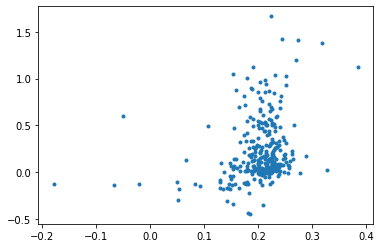

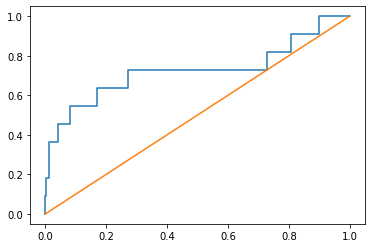

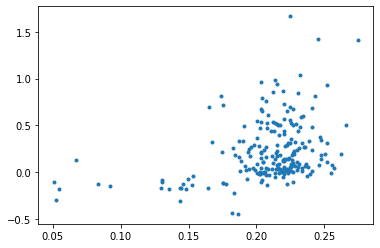

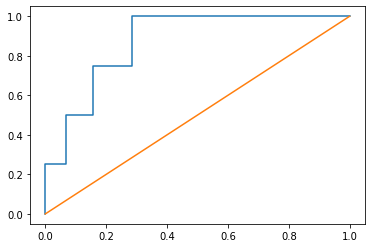

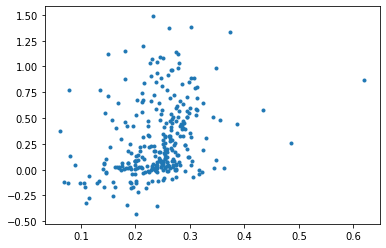

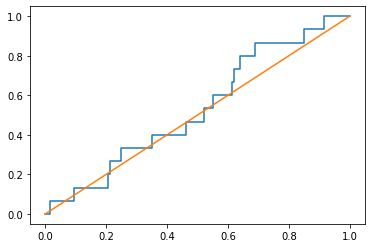

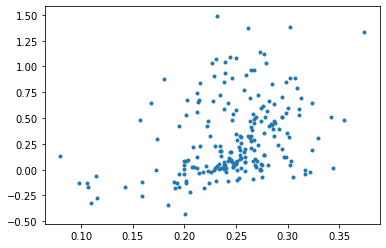

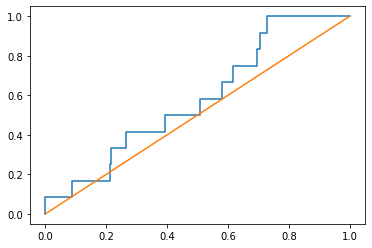

In [305]:
for i in range(2):
    optimal_model = all_dense_model(use_gexp = True, use_gexp_comp = True, use_cos = False, gexp_input_dim = 12328)
    optimal_epoch = optimal_epochs[i]
    weights_fname = 'Model_checkpoints/cov2_comp/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_model.load_weights(weights_fname)
    all_corrs[i], all_aucs[i], all_ns[i], good_corrs[i], good_aucs[i], good_ns[i] = get_performance(optimal_model.predict([np.array(all_cv_tests[i][0]),
                                   np.array(all_cv_tests[i][4]),
                                   np.array(all_cv_tests[i][5])]),
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)

In [307]:
all_corrs

[0.27509928485293456,
 0.30065136093535516,
 [85, 70, ((31894, 12328), 8), ((31894, 12328), 8), ((31894, 12328), 8)],
 [85, 70, ((31894, 12328), 8), ((31894, 12328), 8), ((31894, 12328), 8)],
 [85, 70, ((31894, 12328), 8), ((31894, 12328), 8), ((31894, 12328), 8)]]

In [308]:
print(np.mean(all_corrs[:2]))
print(np.mean(all_aucs[:2]))

print(np.mean(good_corrs[:2]))
print(np.mean(good_aucs[:2]))

print(all_aucs[:2])
print(good_aucs[:2])

0.28787532289414486
0.6298155362434654
0.35241079080430593
0.7275656814449918
[0.7253521126760563, 0.5342789598108747]
[0.8726190476190476, 0.5825123152709359]


## Okay now try the model using cosine similarity

In [309]:
cv_models_cos_sim = [
    all_dense_model(
        use_gexp = True, use_gexp_comp = False,
        use_cos = True, gexp_input_dim = 12328
    )
    for i in range(5)
]

In [85]:
for i in [1,2,3,4]:
    try:
        os.makedirs('Model_checkpoints/cos_sim/fold_'+str(i))
    except:
        pass
    checkpoint_path = 'Model_checkpoints/cos_sim/fold_'+str(i)+'/saved-model-{epoch:02d}.hdf5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=False,
        period = 5
    )
    
    cv_trains = all_cv_trains[i]
    cv_vals = all_cv_vals[i]
    cv_tests = all_cv_tests[i]
    cv_models_cos_sim[i].fit([np.array(cv_trains[0]), np.array(cv_trains[2]), np.array(cv_trains[5])], cv_trains[6],
                     batch_size = 64, epochs = 150,
                     sample_weight = np.array(cv_trains[7]),
                     shuffle = True, callbacks = [model_checkpoint_callback])

Epoch 1/150
21135/21135 [==============================] - 7s 341us/step - loss: 0.4814
Epoch 2/150
21135/21135 [==============================] - 6s 288us/step - loss: 0.2606
Epoch 3/150
21135/21135 [==============================] - 6s 284us/step - loss: 0.0505
Epoch 4/150
21135/21135 [==============================] - 6s 282us/step - loss: 0.0432
Epoch 5/150
21135/21135 [==============================] - 6s 285us/step - loss: 0.0367
Epoch 6/150
21135/21135 [==============================] - 7s 311us/step - loss: 0.0135
Epoch 7/150
21135/21135 [==============================] - 6s 288us/step - loss: 0.0099
Epoch 8/150
21135/21135 [==============================] - 6s 288us/step - loss: 0.0262
Epoch 9/150
21135/21135 [==============================] - 6s 282us/step - loss: 0.0145
Epoch 10/150
21135/21135 [==============================] - 6s 283us/step - loss: 0.0093
Epoch 11/150
21135/21135 [==============================] - 6s 303us/step - loss: 0.0069
Epoch 12/150
21135/21135 [====

20927/20927 [==============================] - 7s 354us/step - loss: 0.0062
Epoch 35/150
20927/20927 [==============================] - 7s 347us/step - loss: 0.0066
Epoch 36/150
20927/20927 [==============================] - 7s 344us/step - loss: 0.0056
Epoch 37/150
20927/20927 [==============================] - 7s 331us/step - loss: 0.0055
Epoch 38/150
20927/20927 [==============================] - 7s 335us/step - loss: 0.0055
Epoch 39/150
20927/20927 [==============================] - 7s 323us/step - loss: 0.0053
Epoch 40/150
20927/20927 [==============================] - 6s 307us/step - loss: 0.0066
Epoch 41/150
20927/20927 [==============================] - 7s 324us/step - loss: 0.0055
Epoch 42/150
20927/20927 [==============================] - 6s 310us/step - loss: 0.0054
Epoch 43/150
20927/20927 [==============================] - 7s 312us/step - loss: 0.0053
Epoch 44/150
20927/20927 [==============================] - 7s 314us/step - loss: 0.0052
Epoch 45/150
20927/20927 [========

21905/21905 [==============================] - 8s 360us/step - loss: 0.0052
Epoch 68/150
21905/21905 [==============================] - 8s 345us/step - loss: 0.0052
Epoch 69/150
21905/21905 [==============================] - 8s 347us/step - loss: 0.0052
Epoch 70/150
21905/21905 [==============================] - 8s 351us/step - loss: 0.0052
Epoch 71/150
21905/21905 [==============================] - 8s 353us/step - loss: 0.0052
Epoch 72/150
21905/21905 [==============================] - 7s 330us/step - loss: 0.0052
Epoch 73/150
21905/21905 [==============================] - 7s 323us/step - loss: 0.0052
Epoch 74/150
21905/21905 [==============================] - 7s 320us/step - loss: 0.0052
Epoch 75/150
21905/21905 [==============================] - 7s 320us/step - loss: 0.0052
Epoch 76/150
21905/21905 [==============================] - 7s 334us/step - loss: 0.0052
Epoch 77/150
21905/21905 [==============================] - 7s 332us/step - loss: 0.0052
Epoch 78/150
21905/21905 [========

20626/20626 [==============================] - 7s 325us/step - loss: 0.0051
Epoch 101/150
20626/20626 [==============================] - 7s 343us/step - loss: 0.0051
Epoch 102/150
20626/20626 [==============================] - 7s 319us/step - loss: 0.0051
Epoch 103/150
20626/20626 [==============================] - 7s 317us/step - loss: 0.0052
Epoch 104/150
20626/20626 [==============================] - 7s 317us/step - loss: 0.0051
Epoch 105/150
20626/20626 [==============================] - 7s 319us/step - loss: 0.0051
Epoch 106/150
20626/20626 [==============================] - 7s 341us/step - loss: 0.0052
Epoch 107/150
20626/20626 [==============================] - 7s 327us/step - loss: 0.0051
Epoch 108/150
20626/20626 [==============================] - 7s 329us/step - loss: 0.0051
Epoch 109/150
20626/20626 [==============================] - 7s 328us/step - loss: 0.0051
Epoch 110/150
20626/20626 [==============================] - 7s 347us/step - loss: 0.0051
Epoch 111/150
20626/2062

In [80]:
optimal_epochs_cos_sim = [_ for i in range(5)]

In [86]:
for i in range(1,5):
    epochs = []
    corrs = []
    model_to_optimize = all_dense_model(use_gexp = True, use_gexp_comp = False, use_cos = True, gexp_input_dim = 12328)
    weights_path = 'Model_checkpoints/cos_sim/fold_'+str(i)
    model_weights = os.listdir(weights_path)
#     print(model_weights)
    for weight_fname in model_weights:
        if weight_fname[0:5] == 'saved':
#             print(weight_fname)
            model_to_optimize.load_weights(weights_path + '/' + weight_fname)
            n_epochs = int(weight_fname.split('.')[0].split('-')[2])
            epochs.append(n_epochs)
            corrs.append(get_corr_only(model_to_optimize.predict([np.array(all_cv_vals[i][0]),
                                                               np.array(all_cv_vals[i][2]),
                                                               np.array(all_cv_vals[i][5])]),
                                         all_cv_vals[i][6], ref_pert_df, good_cutoff = 4.5))
    print(max(corrs))
    optimal_epoch = epochs[np.argmax(corrs)]
    print(optimal_epoch)
    optimal_epochs_cos_sim[i] = optimal_epoch
    

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.25193387738882755
130
0.3664827668398506
150
0.3045277407854295
40
0.27571979570348887
45


In [87]:
all_aucs_cos_sim = [_ for i in range(5)]
all_corrs_cos_sim = [_ for i in range(5)]
all_ns_cos_sim = [_ for i in range(5)]
good_aucs_cos_sim = [_ for i in range(5)]
good_corrs_cos_sim = [_ for i in range(5)]
good_ns_cos_sim = [_ for i in range(5)]

Using all perturbagens from test set:
Pearson rho:  0.23345054841902793
AUC:  0.7007042253521126
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3527620949259444
AUC:  0.6916666666666667
n:  214




/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Using all perturbagens from test set:
Pearson rho:  nan
AUC:  0.5
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  nan
AUC:  0.5
n:  215


Using all perturbagens from test set:
Pearson rho:  0.24015356549608669
AUC:  0.6680250783699059
n:  312
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.23971276866548208
AUC:  0.6196078431372549
n:  227


Using all perturbagens from test set:
Pearson rho:  0.15789848310629034
AUC:  0.49353002070393376
n:  290
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.2873054493251977
AUC:  0.6099773242630385
n:  205


Using all perturbagens from test set:
Pearson rho:  0.20043138257567542
AUC:  0.5040885040885041
n:  318
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.18332467122887056
AUC:  0.44787644787644787
n:  236




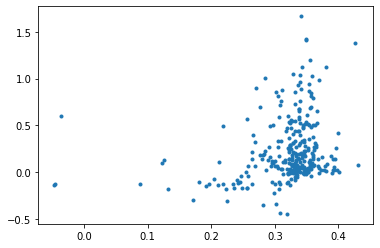

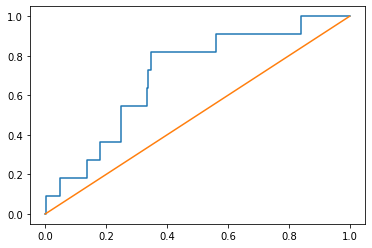

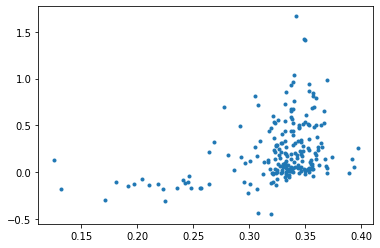

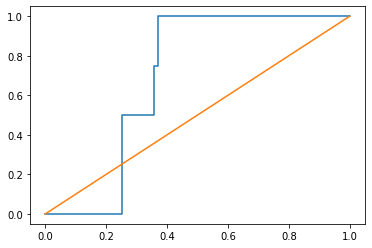

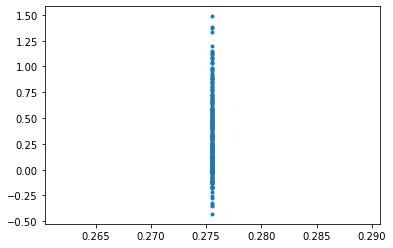

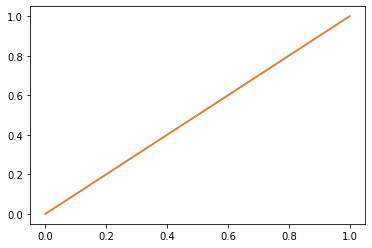

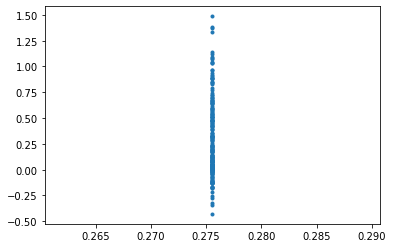

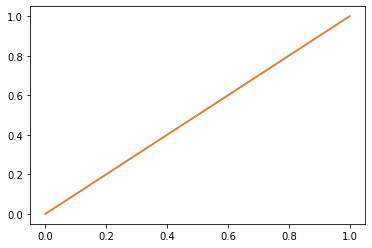

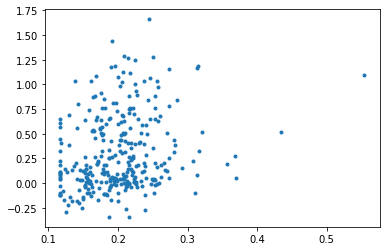

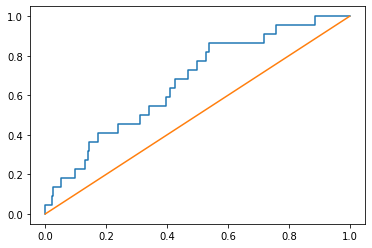

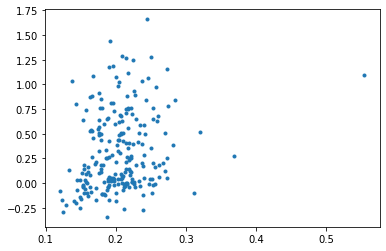

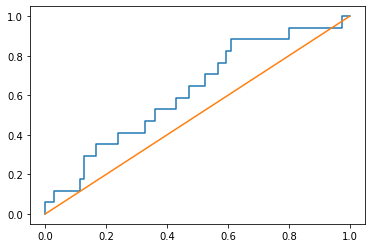

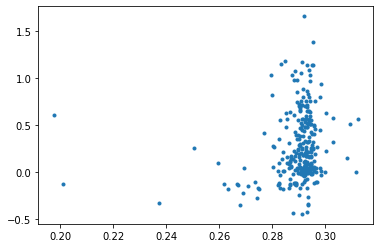

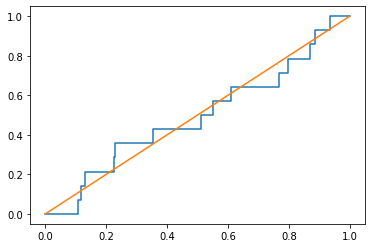

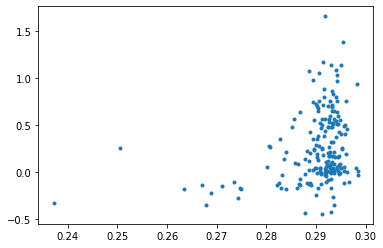

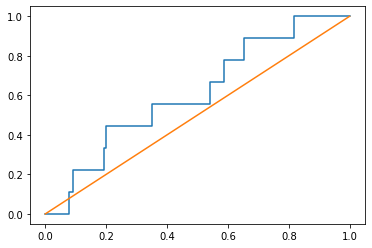

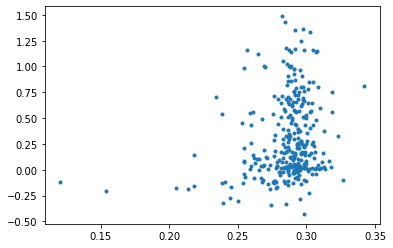

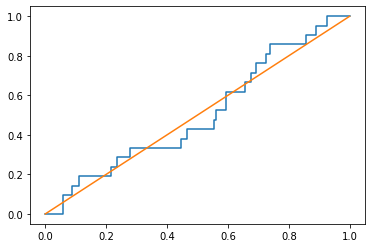

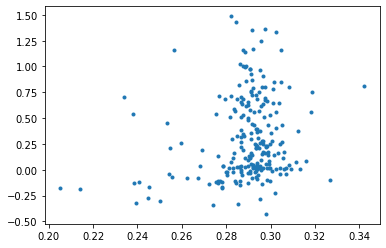

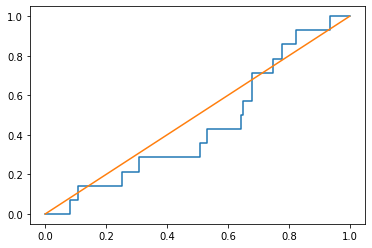

In [88]:
for i in range(5):
    optimal_model = all_dense_model(use_gexp = True, use_gexp_comp = False, use_cos = True, gexp_input_dim = 12328)
    optimal_epoch = optimal_epochs_cos_sim[i]
    weights_fname = 'Model_checkpoints/cos_sim/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_model.load_weights(weights_fname)
    all_corrs_cos_sim[i], all_aucs_cos_sim[i], all_ns_cos_sim[i], good_corrs_cos_sim[i], good_aucs_cos_sim[i], good_ns_cos_sim[i] = get_performance(optimal_model.predict([np.array(all_cv_tests[i][0]),
                                   np.array(all_cv_tests[i][2]),
                                   np.array(all_cv_tests[i][5])]),
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)
    

In [89]:
print(np.mean(all_corrs_cos_sim))
print(np.mean(all_aucs_cos_sim))

print(np.mean(good_corrs_cos_sim))
print(np.mean(good_aucs_cos_sim))

print(all_aucs_cos_sim)
print(good_aucs_cos_sim)

nan
0.5732695657028912
nan
0.5738256563886817
[0.7007042253521126, 0.5, 0.6680250783699059, 0.49353002070393376, 0.5040885040885041]
[0.6916666666666667, 0.5, 0.6196078431372549, 0.6099773242630385, 0.44787644787644787]


# Okay now try using absolute value cosine similarity

In [90]:
cv_models_cos_sim_abs = [all_dense_model(use_gexp = True, use_gexp_comp = False, use_cos = True, gexp_input_dim = 12328) for i in range(5)]


In [91]:
for i in [0,1,2,3,4]:
    try:
        os.makedirs('Model_checkpoints/cos_sim_abs/fold_'+str(i))
    except:
        pass
    checkpoint_path = 'Model_checkpoints/cos_sim_abs/fold_'+str(i)+'/saved-model-{epoch:02d}.hdf5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=False,
        period = 5
    )
    
    cv_trains = all_cv_trains[i]
    cv_vals = all_cv_vals[i]
    cv_tests = all_cv_tests[i]
    cv_models_cos_sim_abs[i].fit([np.array(cv_trains[0]), np.array(cv_trains[3]), np.array(cv_trains[5])], cv_trains[6],
                     batch_size = 64, epochs = 150,
                     sample_weight = np.array(cv_trains[7]),
                     shuffle = True, callbacks = [model_checkpoint_callback])

Epoch 1/150
21364/21364 [==============================] - 9s 438us/step - loss: 1.1114
Epoch 2/150
21364/21364 [==============================] - 6s 303us/step - loss: 0.8570
Epoch 3/150
21364/21364 [==============================] - 7s 314us/step - loss: 0.4089
Epoch 4/150
21364/21364 [==============================] - 7s 308us/step - loss: 0.1348
Epoch 5/150
21364/21364 [==============================] - 7s 308us/step - loss: 0.0738
Epoch 6/150
21364/21364 [==============================] - 7s 338us/step - loss: 0.0439
Epoch 7/150
21364/21364 [==============================] - 7s 326us/step - loss: 0.1171
Epoch 8/150
21364/21364 [==============================] - 7s 322us/step - loss: 0.0921
Epoch 9/150
21364/21364 [==============================] - 7s 316us/step - loss: 0.0788
Epoch 10/150
21364/21364 [==============================] - 7s 332us/step - loss: 0.0698
Epoch 11/150
21364/21364 [==============================] - 7s 337us/step - loss: 0.0224
Epoch 12/150
21364/21364 [====

21135/21135 [==============================] - 7s 309us/step - loss: 0.0065
Epoch 35/150
21135/21135 [==============================] - 6s 296us/step - loss: 0.0063
Epoch 36/150
21135/21135 [==============================] - 7s 331us/step - loss: 0.0075
Epoch 37/150
21135/21135 [==============================] - 7s 338us/step - loss: 0.0067
Epoch 38/150
21135/21135 [==============================] - 8s 356us/step - loss: 0.0074
Epoch 39/150
21135/21135 [==============================] - 7s 343us/step - loss: 0.0070
Epoch 40/150
21135/21135 [==============================] - 7s 334us/step - loss: 0.0082
Epoch 41/150
21135/21135 [==============================] - 7s 340us/step - loss: 0.0068
Epoch 42/150
21135/21135 [==============================] - 7s 316us/step - loss: 0.0078
Epoch 43/150
21135/21135 [==============================] - 7s 322us/step - loss: 0.0106
Epoch 44/150
21135/21135 [==============================] - 6s 306us/step - loss: 0.0070
Epoch 45/150
21135/21135 [========

20927/20927 [==============================] - 6s 303us/step - loss: 0.0052
Epoch 68/150
20927/20927 [==============================] - 6s 303us/step - loss: 0.0052
Epoch 69/150
20927/20927 [==============================] - 6s 288us/step - loss: 0.0052
Epoch 70/150
20927/20927 [==============================] - 6s 281us/step - loss: 0.0052
Epoch 71/150
20927/20927 [==============================] - 6s 300us/step - loss: 0.0052
Epoch 72/150
20927/20927 [==============================] - 6s 309us/step - loss: 0.0052
Epoch 73/150
20927/20927 [==============================] - 6s 290us/step - loss: 0.0052
Epoch 74/150
20927/20927 [==============================] - 6s 299us/step - loss: 0.0052
Epoch 75/150
20927/20927 [==============================] - 6s 302us/step - loss: 0.0052
Epoch 76/150
20927/20927 [==============================] - 7s 325us/step - loss: 0.0052
Epoch 77/150
20927/20927 [==============================] - 6s 310us/step - loss: 0.0052
Epoch 78/150
20927/20927 [========

Epoch 100/150
21905/21905 [==============================] - 7s 300us/step - loss: 0.0052
Epoch 101/150
21905/21905 [==============================] - 7s 328us/step - loss: 0.0052
Epoch 102/150
21905/21905 [==============================] - 7s 322us/step - loss: 0.0052
Epoch 103/150
21905/21905 [==============================] - 7s 312us/step - loss: 0.0052
Epoch 104/150
21905/21905 [==============================] - 7s 311us/step - loss: 0.0052
Epoch 105/150
21905/21905 [==============================] - 7s 314us/step - loss: 0.0052
Epoch 106/150
21905/21905 [==============================] - 8s 343us/step - loss: 0.0052
Epoch 107/150
21905/21905 [==============================] - 8s 348us/step - loss: 0.0052
Epoch 108/150
21905/21905 [==============================] - 8s 351us/step - loss: 0.0052
Epoch 109/150
21905/21905 [==============================] - 7s 336us/step - loss: 0.0052
Epoch 110/150
21905/21905 [==============================] - 7s 335us/step - loss: 0.0052
Epoch 111/

20626/20626 [==============================] - 7s 348us/step - loss: 0.0028
Epoch 133/150
20626/20626 [==============================] - 7s 350us/step - loss: 0.0028
Epoch 134/150
20626/20626 [==============================] - 7s 338us/step - loss: 0.0028
Epoch 135/150
20626/20626 [==============================] - 7s 361us/step - loss: 0.0028
Epoch 136/150
20626/20626 [==============================] - 8s 376us/step - loss: 0.0027
Epoch 137/150
20626/20626 [==============================] - 8s 367us/step - loss: 0.0028
Epoch 138/150
20626/20626 [==============================] - 9s 458us/step - loss: 0.0028
Epoch 139/150
20626/20626 [==============================] - 11s 521us/step - loss: 0.0027
Epoch 140/150
20626/20626 [==============================] - 9s 440us/step - loss: 0.0028
Epoch 141/150
20626/20626 [==============================] - 9s 427us/step - loss: 0.0050
Epoch 142/150
20626/20626 [==============================] - 8s 374us/step - loss: 0.0051
Epoch 143/150
20626/206

In [92]:
optimal_epochs_cos_sim_abs = [_ for i in range(5)]

In [93]:
for i in range(5):
    epochs = []
    corrs = []
    model_to_optimize = all_dense_model(use_gexp = True, use_gexp_comp = False, use_cos = True, gexp_input_dim = 12328)
    weights_path = 'Model_checkpoints/cos_sim_abs/fold_'+str(i)
    model_weights = os.listdir(weights_path)
#     print(model_weights)
    for weight_fname in model_weights:
        if weight_fname[0:5] == 'saved':
#             print(weight_fname)
            model_to_optimize.load_weights(weights_path + '/' + weight_fname)
            n_epochs = int(weight_fname.split('.')[0].split('-')[2])
            epochs.append(n_epochs)
            corrs.append(get_corr_only(model_to_optimize.predict([np.array(all_cv_vals[i][0]),
                                                               np.array(all_cv_vals[i][3]),
                                                               np.array(all_cv_vals[i][5])]),
                                         all_cv_vals[i][6], ref_pert_df, good_cutoff = 4.5))
    print(max(corrs))
    optimal_epoch = epochs[np.argmax(corrs)]
    print(optimal_epoch)
    optimal_epochs_cos_sim_abs[i] = optimal_epoch

0.4695936798172356
50
0.3342488683039913
75
0.2771186884041122
60


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.2679119328114296
75
0.4552627541507835
150


In [94]:
all_aucs_cos_sim_abs = [_ for i in range(5)]
all_corrs_cos_sim_abs = [_ for i in range(5)]
all_ns_cos_sim_abs = [_ for i in range(5)]
good_aucs_cos_sim_abs = [_ for i in range(5)]
good_corrs_cos_sim_abs = [_ for i in range(5)]
good_ns_cos_sim_abs = [_ for i in range(5)]

Using all perturbagens from test set:
Pearson rho:  0.21334436083767527
AUC:  0.5384122919334187
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.31469156261149295
AUC:  0.6178571428571429
n:  214


Using all perturbagens from test set:
Pearson rho:  0.21893496650065244
AUC:  0.49550827423167854
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.28805302715143716
AUC:  0.5036945812807881
n:  215


Using all perturbagens from test set:
Pearson rho:  0.2202432723420604
AUC:  0.6471786833855799
n:  312
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.29721998310898823
AUC:  0.65406162464986
n:  227




/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Using all perturbagens from test set:
Pearson rho:  nan
AUC:  0.5
n:  290
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  nan
AUC:  0.5
n:  205


Using all perturbagens from test set:
Pearson rho:  0.26608943135705526
AUC:  0.6620169953503288
n:  318
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.2530848588825701
AUC:  0.593951093951094
n:  236




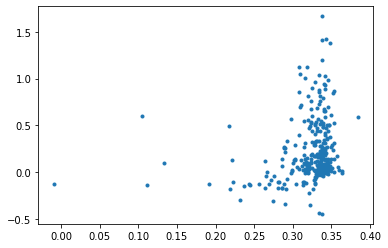

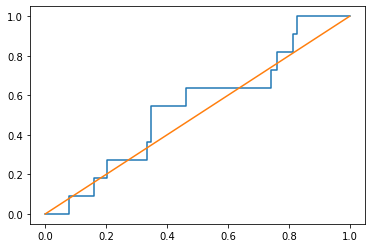

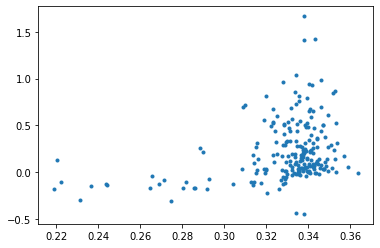

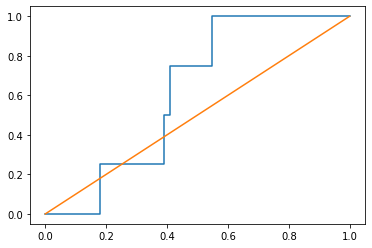

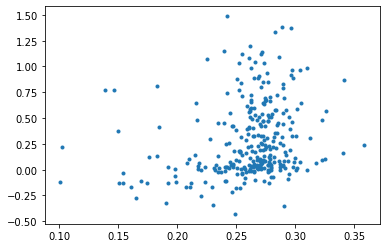

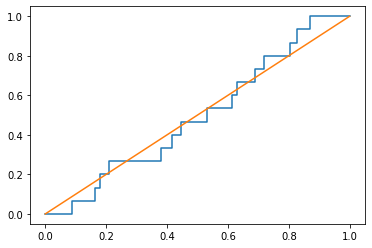

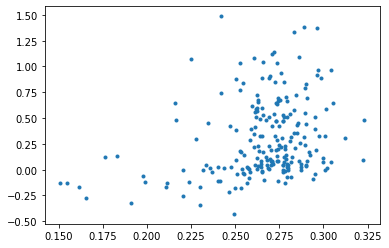

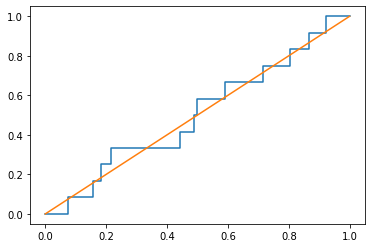

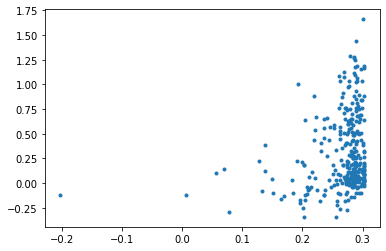

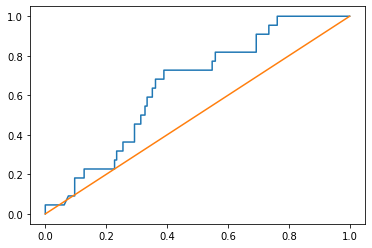

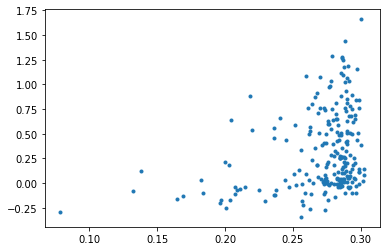

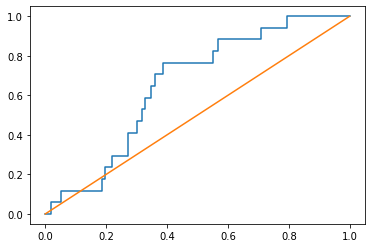

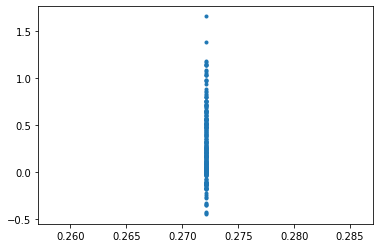

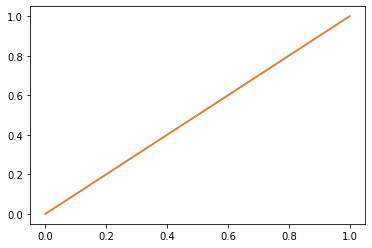

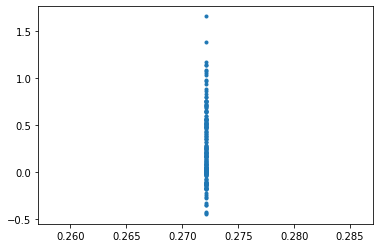

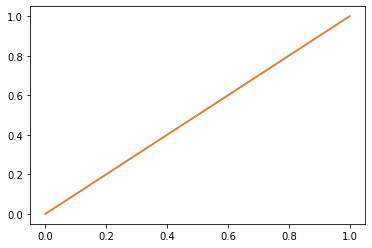

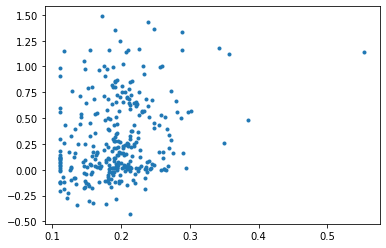

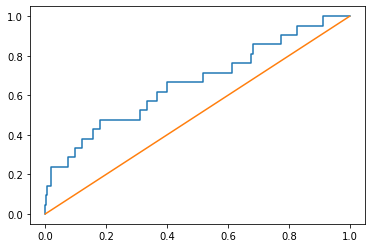

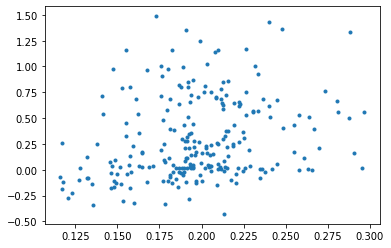

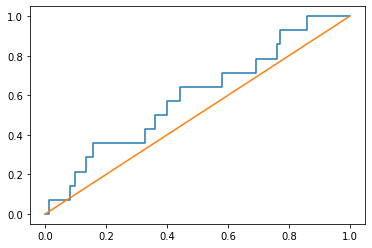

In [95]:
for i in range(5):
    optimal_model = all_dense_model(use_gexp = True, use_gexp_comp = False, use_cos = True, gexp_input_dim = 12328)
    optimal_epoch = optimal_epochs_cos_sim_abs[i]
    weights_fname = 'Model_checkpoints/cos_sim_abs/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_model.load_weights(weights_fname)
    all_corrs_cos_sim_abs[i], all_aucs_cos_sim_abs[i], all_ns_cos_sim_abs[i], good_corrs_cos_sim_abs[i], good_aucs_cos_sim_abs[i], good_ns_cos_sim_abs[i] = get_performance(optimal_model.predict([np.array(all_cv_tests[i][0]),
                                   np.array(all_cv_tests[i][3]),
                                   np.array(all_cv_tests[i][5])]),
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)
    

In [97]:
print(np.mean(all_corrs_cos_sim_abs))
print(np.mean(all_aucs_cos_sim_abs))

print(np.mean(good_corrs_cos_sim_abs))
print(np.mean(good_aucs_cos_sim_abs))

print(all_aucs_cos_sim_abs)
print(good_aucs_cos_sim_abs)

nan
0.5686232489802012
nan
0.573912888547777
[0.5384122919334187, 0.49550827423167854, 0.6471786833855799, 0.5, 0.6620169953503288]
[0.6178571428571429, 0.5036945812807881, 0.65406162464986, 0.5, 0.593951093951094]


In [ ]:
# Other things to do:
# Expression only
# Expression plus cell line
# Normalized expression
# Interactome expression only
# The winner of all without dose, plus dose

# Expression only

In [98]:
cv_models_exp_only = [dense_regression_model() for i in range(5)]


In [100]:
for i in [0,1,2,3,4]:
    try:
        os.makedirs('Model_checkpoints/expr_only/fold_'+str(i))
    except:
        pass
    checkpoint_path = 'Model_checkpoints/expr_only/fold_'+str(i)+'/saved-model-{epoch:02d}.hdf5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=False,
        period = 5
    )
    
    cv_trains = all_cv_trains[i]
    cv_vals = all_cv_vals[i]
    cv_tests = all_cv_tests[i]
    cv_models_exp_only[i].fit(np.array(cv_trains[0]), cv_trains[6],
                     batch_size = 64, epochs = 150,
                     sample_weight = np.array(cv_trains[7]),
                     shuffle = True, callbacks = [model_checkpoint_callback])

Epoch 1/150
21364/21364 [==============================] - 9s 413us/step - loss: 0.0343
Epoch 2/150
21364/21364 [==============================] - 7s 326us/step - loss: 0.0081
Epoch 3/150
21364/21364 [==============================] - 7s 325us/step - loss: 0.0072
Epoch 4/150
21364/21364 [==============================] - 7s 310us/step - loss: 0.0059
Epoch 5/150
21364/21364 [==============================] - 7s 318us/step - loss: 0.0056
Epoch 6/150
21364/21364 [==============================] - 7s 342us/step - loss: 0.0050
Epoch 7/150
21364/21364 [==============================] - 7s 313us/step - loss: 0.0047
Epoch 8/150
21364/21364 [==============================] - 7s 316us/step - loss: 0.0045
Epoch 9/150
21364/21364 [==============================] - 7s 331us/step - loss: 0.0044
Epoch 10/150
21364/21364 [==============================] - 7s 345us/step - loss: 0.0042
Epoch 11/150
21364/21364 [==============================] - 13s 629us/step - loss: 0.00430s - loss: 0.0
Epoch 12/150
21

21135/21135 [==============================] - 7s 351us/step - loss: 0.0030
Epoch 30/150
21135/21135 [==============================] - 7s 328us/step - loss: 0.0029
Epoch 31/150
21135/21135 [==============================] - 7s 344us/step - loss: 0.0028
Epoch 32/150
21135/21135 [==============================] - 7s 330us/step - loss: 0.0029
Epoch 33/150
21135/21135 [==============================] - 7s 325us/step - loss: 0.0028
Epoch 34/150
21135/21135 [==============================] - 7s 345us/step - loss: 0.0027
Epoch 35/150
21135/21135 [==============================] - 8s 366us/step - loss: 0.0027
Epoch 36/150
21135/21135 [==============================] - 8s 396us/step - loss: 0.0027
Epoch 37/150
21135/21135 [==============================] - 7s 342us/step - loss: 0.0025
Epoch 38/150
21135/21135 [==============================] - 7s 347us/step - loss: 0.0025
Epoch 39/150
21135/21135 [==============================] - 7s 348us/step - loss: 0.0023
Epoch 40/150
21135/21135 [========

20927/20927 [==============================] - 6s 290us/step - loss: 0.0014
Epoch 60/150
20927/20927 [==============================] - 6s 288us/step - loss: 0.0015
Epoch 61/150
20927/20927 [==============================] - 7s 328us/step - loss: 0.0014
Epoch 62/150
20927/20927 [==============================] - 6s 278us/step - loss: 0.0013
Epoch 63/150
20927/20927 [==============================] - 6s 282us/step - loss: 0.0013
Epoch 64/150
20927/20927 [==============================] - 6s 289us/step - loss: 0.0013
Epoch 65/150
20927/20927 [==============================] - 6s 279us/step - loss: 0.0013
Epoch 66/150
20927/20927 [==============================] - 7s 347us/step - loss: 0.0013
Epoch 67/150
20927/20927 [==============================] - 7s 311us/step - loss: 0.0013
Epoch 68/150
20927/20927 [==============================] - 6s 299us/step - loss: 0.0012
Epoch 69/150
20927/20927 [==============================] - 6s 292us/step - loss: 0.0012
Epoch 70/150
20927/20927 [========

21905/21905 [==============================] - 11s 499us/step - loss: 7.6498e-04
Epoch 88/150
21905/21905 [==============================] - 10s 459us/step - loss: 7.5864e-04
Epoch 89/150
21905/21905 [==============================] - 9s 428us/step - loss: 6.5635e-04
Epoch 90/150
21905/21905 [==============================] - 9s 413us/step - loss: 6.8053e-04
Epoch 91/150
21905/21905 [==============================] - 10s 462us/step - loss: 6.5006e-04
Epoch 92/150
21905/21905 [==============================] - 9s 428us/step - loss: 6.8999e-04
Epoch 93/150
21905/21905 [==============================] - 10s 460us/step - loss: 7.8515e-04
Epoch 94/150
21905/21905 [==============================] - 10s 444us/step - loss: 6.4002e-04
Epoch 95/150
21905/21905 [==============================] - 12s 555us/step - loss: 6.6178e-04
Epoch 96/150
21905/21905 [==============================] - 12s 542us/step - loss: 6.4895e-04
Epoch 97/150
21905/21905 [==============================] - 10s 468us/step -

Epoch 25/150
20626/20626 [==============================] - 11s 528us/step - loss: 0.0027
Epoch 26/150
20626/20626 [==============================] - 13s 626us/step - loss: 0.0027
Epoch 27/150
20626/20626 [==============================] - 11s 553us/step - loss: 0.0027
Epoch 28/150
20626/20626 [==============================] - 10s 507us/step - loss: 0.0025
Epoch 29/150
20626/20626 [==============================] - 10s 477us/step - loss: 0.0025
Epoch 30/150
20626/20626 [==============================] - 9s 441us/step - loss: 0.0024
Epoch 31/150
20626/20626 [==============================] - 10s 478us/step - loss: 0.0023
Epoch 32/150
20626/20626 [==============================] - 10s 466us/step - loss: 0.0022
Epoch 33/150
20626/20626 [==============================] - 11s 517us/step - loss: 0.0021
Epoch 34/150
20626/20626 [==============================] - 10s 503us/step - loss: 0.0021
Epoch 35/150
20626/20626 [==============================] - 11s 545us/step - loss: 0.0022
Epoch 36/15

In [101]:
optimal_epochs_exp_only = [_ for i in range(5)]

In [104]:
for i in range(5):
    epochs = []
    corrs = []
    model_to_optimize = dense_regression_model()
    weights_path = 'Model_checkpoints/expr_only/fold_'+str(i)
    model_weights = os.listdir(weights_path)
#     print(model_weights)
    for weight_fname in model_weights:
        if weight_fname[0:5] == 'saved':
#             print(weight_fname)
            model_to_optimize.load_weights(weights_path + '/' + weight_fname)
            n_epochs = int(weight_fname.split('.')[0].split('-')[2])
            epochs.append(n_epochs)
            corrs.append(get_corr_only(model_to_optimize.predict(np.array(all_cv_vals[i][0])),
                                         all_cv_vals[i][6], ref_pert_df, good_cutoff = 4.5))
    print(max(corrs))
    optimal_epoch = epochs[np.argmax(corrs)]
    print(optimal_epoch)
    optimal_epochs_exp_only[i] = optimal_epoch

0.4567092792107053
35
0.4329066975002038
65
0.29763179587955313
35
0.45038074324024713
65
0.4922196625945371
145


In [105]:
all_aucs_exp_only = [_ for i in range(5)]
all_corrs_exp_only = [_ for i in range(5)]
all_ns_exp_only = [_ for i in range(5)]
good_aucs_exp_only = [_ for i in range(5)]
good_corrs_exp_only = [_ for i in range(5)]
good_ns_exp_only = [_ for i in range(5)]

Using all perturbagens from test set:
Pearson rho:  0.2518109644272186
AUC:  0.706786171574904
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.34461904800861376
AUC:  0.8130952380952381
n:  214


Using all perturbagens from test set:
Pearson rho:  0.27946660805206075
AUC:  0.6040189125295508
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3682824507281417
AUC:  0.6666666666666666
n:  215


Using all perturbagens from test set:
Pearson rho:  0.27177080127595277
AUC:  0.663949843260188
n:  312
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.25897152707081866
AUC:  0.5787114845938375
n:  227


Using all perturbagens from test set:
Pearson rho:  0.3552906394105515
AUC:  0.7070393374741201
n:  290
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.31321323831559816
AUC:  0.5651927437641724
n:  205


Using all perturbagens from test set:
Pearson rho:  0.3539142146407554
AUC:  

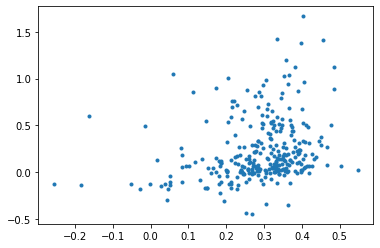

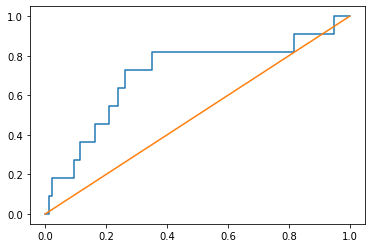

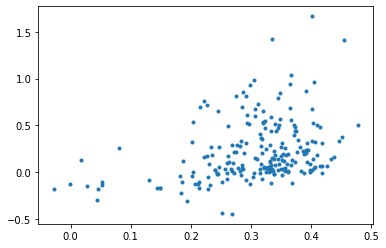

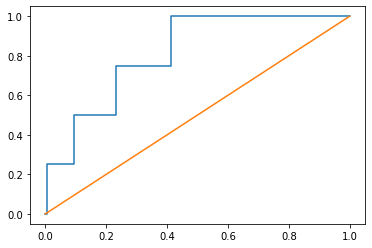

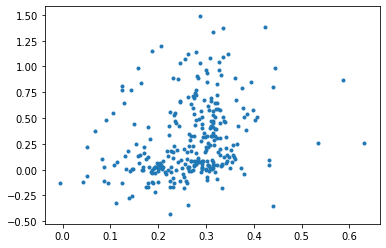

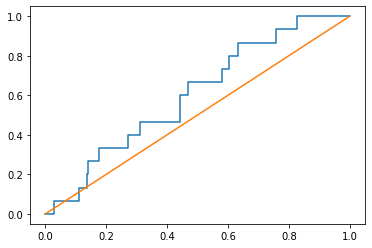

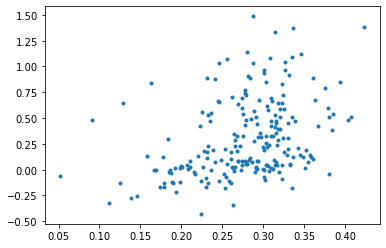

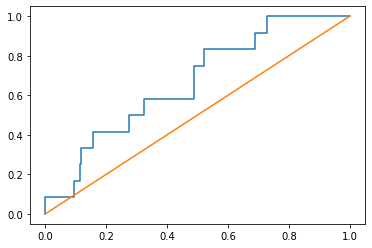

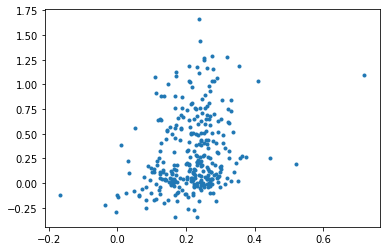

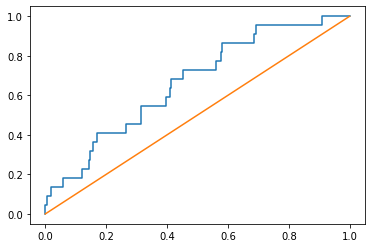

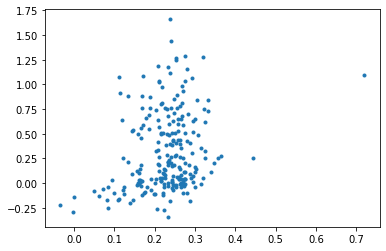

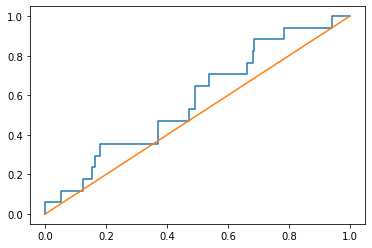

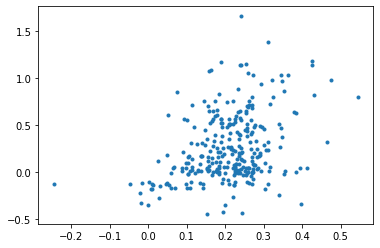

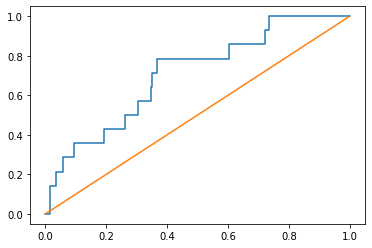

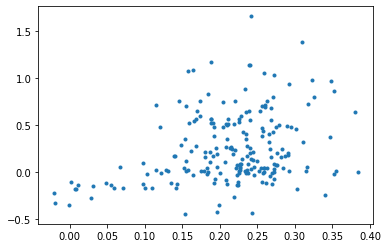

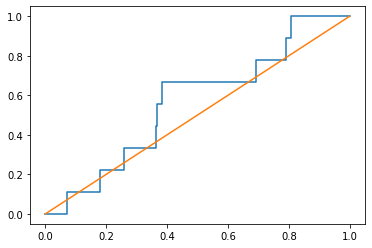

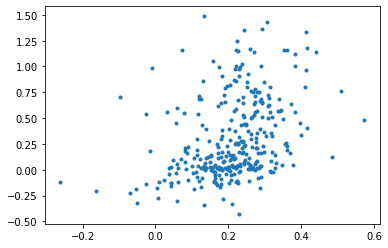

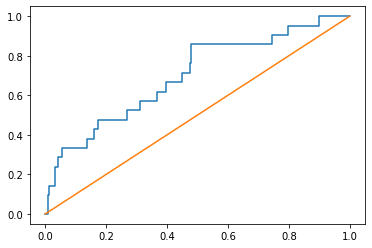

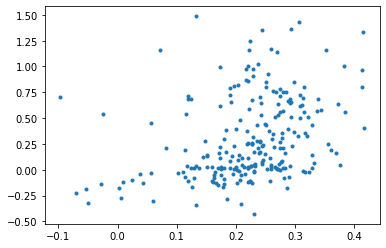

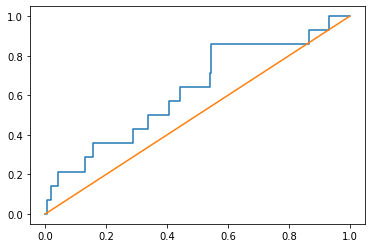

In [107]:
for i in range(5):
    optimal_model = dense_regression_model()
    optimal_epoch = optimal_epochs_exp_only[i]
    weights_fname = 'Model_checkpoints/expr_only/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_model.load_weights(weights_fname)
    all_corrs_exp_only[i], all_aucs_exp_only[i], all_ns_exp_only[i], good_corrs_exp_only[i], good_aucs_exp_only[i], good_ns_exp_only[i] = get_performance(optimal_model.predict(np.array(all_cv_tests[i][0])),
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)
    

In [109]:
print(np.mean(all_corrs_exp_only))
print(np.mean(all_aucs_exp_only))

print(np.mean(good_corrs_exp_only))
print(np.mean(good_aucs_exp_only))

print(all_aucs_exp_only)
print(good_aucs_exp_only)

0.3024506455613078
0.6761375927464923
0.32466638804245107
0.649701051591808
[0.706786171574904, 0.6040189125295508, 0.663949843260188, 0.7070393374741201, 0.6988936988936988]
[0.8130952380952381, 0.6666666666666666, 0.5787114845938375, 0.5651927437641724, 0.6248391248391248]


# Interactome expression only

In [122]:
cv_models_interactome_only = [dense_regression_model(input_dim = 278) for i in range(5)]


In [123]:
for i in [0,1,2,3,4]:
    try:
        os.makedirs('Model_checkpoints/interactome_only/fold_'+str(i))
    except:
        pass
    checkpoint_path = 'Model_checkpoints/interactome_only/fold_'+str(i)+'/saved-model-{epoch:02d}.hdf5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=False,
        period = 5
    )
    
    cv_trains = all_cv_trains[i]
    cv_vals = all_cv_vals[i]
    cv_tests = all_cv_tests[i]
    cv_models_interactome_only[i].fit(np.array(cv_trains[1]), cv_trains[6],
                     batch_size = 64, epochs = 150,
                     sample_weight = np.array(cv_trains[7]),
                     shuffle = True, callbacks = [model_checkpoint_callback])

Epoch 1/150
21364/21364 [==============================] - 4s 210us/step - loss: 0.0064
Epoch 2/150
21364/21364 [==============================] - 2s 112us/step - loss: 0.0053
Epoch 3/150
21364/21364 [==============================] - 2s 108us/step - loss: 0.0051
Epoch 4/150
21364/21364 [==============================] - 2s 109us/step - loss: 0.0049
Epoch 5/150
21364/21364 [==============================] - 2s 112us/step - loss: 0.0047
Epoch 6/150
21364/21364 [==============================] - 2s 114us/step - loss: 0.0045
Epoch 7/150
21364/21364 [==============================] - 2s 116us/step - loss: 0.0044
Epoch 8/150
21364/21364 [==============================] - 2s 112us/step - loss: 0.0041
Epoch 9/150
21364/21364 [==============================] - 2s 109us/step - loss: 0.0040
Epoch 10/150
21364/21364 [==============================] - 2s 112us/step - loss: 0.0038
Epoch 11/150
21364/21364 [==============================] - 2s 116us/step - loss: 0.0036
Epoch 12/150
21364/21364 [====

21135/21135 [==============================] - 3s 119us/step - loss: 0.0020
Epoch 35/150
21135/21135 [==============================] - 3s 119us/step - loss: 0.0019
Epoch 36/150
21135/21135 [==============================] - 2s 116us/step - loss: 0.0018
Epoch 37/150
21135/21135 [==============================] - 3s 121us/step - loss: 0.0018
Epoch 38/150
21135/21135 [==============================] - 2s 115us/step - loss: 0.0018
Epoch 39/150
21135/21135 [==============================] - 2s 113us/step - loss: 0.0019
Epoch 40/150
21135/21135 [==============================] - 2s 112us/step - loss: 0.0018
Epoch 41/150
21135/21135 [==============================] - 3s 120us/step - loss: 0.0018
Epoch 42/150
21135/21135 [==============================] - 2s 113us/step - loss: 0.0018
Epoch 43/150
21135/21135 [==============================] - 2s 109us/step - loss: 0.0017
Epoch 44/150
21135/21135 [==============================] - 2s 110us/step - loss: 0.0017
Epoch 45/150
21135/21135 [========

20927/20927 [==============================] - 3s 156us/step - loss: 0.0014
Epoch 67/150
20927/20927 [==============================] - 3s 157us/step - loss: 0.0014
Epoch 68/150
20927/20927 [==============================] - 3s 154us/step - loss: 0.0014
Epoch 69/150
20927/20927 [==============================] - 3s 147us/step - loss: 0.0013
Epoch 70/150
20927/20927 [==============================] - 3s 143us/step - loss: 0.0013
Epoch 71/150
20927/20927 [==============================] - 3s 145us/step - loss: 0.0013
Epoch 72/150
20927/20927 [==============================] - 3s 139us/step - loss: 0.0013
Epoch 73/150
20927/20927 [==============================] - 3s 133us/step - loss: 0.0013
Epoch 74/150
20927/20927 [==============================] - 3s 133us/step - loss: 0.0012 0s - los
Epoch 75/150
20927/20927 [==============================] - 3s 136us/step - loss: 0.0013
Epoch 76/150
20927/20927 [==============================] - 3s 137us/step - loss: 0.0013
Epoch 77/150
20927/20927 

21905/21905 [==============================] - 3s 118us/step - loss: 0.0011
Epoch 99/150
21905/21905 [==============================] - 2s 114us/step - loss: 0.0012
Epoch 100/150
21905/21905 [==============================] - 2s 114us/step - loss: 0.0012
Epoch 101/150
21905/21905 [==============================] - 3s 115us/step - loss: 0.0011
Epoch 102/150
21905/21905 [==============================] - 3s 115us/step - loss: 0.0012
Epoch 103/150
21905/21905 [==============================] - 3s 115us/step - loss: 0.0011
Epoch 104/150
21905/21905 [==============================] - 3s 116us/step - loss: 0.0011
Epoch 105/150
21905/21905 [==============================] - 3s 117us/step - loss: 0.0011
Epoch 106/150
21905/21905 [==============================] - 3s 120us/step - loss: 0.0011
Epoch 107/150
21905/21905 [==============================] - 3s 118us/step - loss: 0.0011
Epoch 108/150
21905/21905 [==============================] - 2s 114us/step - loss: 0.0011
Epoch 109/150
21905/21905

20626/20626 [==============================] - 2s 106us/step - loss: 0.0017
Epoch 40/150
20626/20626 [==============================] - 2s 106us/step - loss: 0.0017
Epoch 41/150
20626/20626 [==============================] - 2s 109us/step - loss: 0.0017
Epoch 42/150
20626/20626 [==============================] - 2s 118us/step - loss: 0.0018
Epoch 43/150
20626/20626 [==============================] - 2s 119us/step - loss: 0.0017
Epoch 44/150
20626/20626 [==============================] - 2s 106us/step - loss: 0.0017
Epoch 45/150
20626/20626 [==============================] - 2s 105us/step - loss: 0.0016
Epoch 46/150
20626/20626 [==============================] - 2s 108us/step - loss: 0.0016
Epoch 47/150
20626/20626 [==============================] - 2s 107us/step - loss: 0.0016
Epoch 48/150
20626/20626 [==============================] - 2s 106us/step - loss: 0.0016
Epoch 49/150
20626/20626 [==============================] - 2s 106us/step - loss: 0.0016
Epoch 50/150
20626/20626 [========

In [124]:
optimal_epochs_interactome_only = [_ for i in range(5)]

In [125]:
for i in range(5):
    epochs = []
    corrs = []
    model_to_optimize = dense_regression_model(input_dim = 278)
    weights_path = 'Model_checkpoints/interactome_only/fold_'+str(i)
    model_weights = os.listdir(weights_path)
#     print(model_weights)
    for weight_fname in model_weights:
        if weight_fname[0:5] == 'saved':
#             print(weight_fname)
            model_to_optimize.load_weights(weights_path + '/' + weight_fname)
            n_epochs = int(weight_fname.split('.')[0].split('-')[2])
            epochs.append(n_epochs)
            corrs.append(get_corr_only(model_to_optimize.predict(np.array(all_cv_vals[i][1])),
                                         all_cv_vals[i][6], ref_pert_df, good_cutoff = 4.5))
    print(max(corrs))
    optimal_epoch = epochs[np.argmax(corrs)]
    print(optimal_epoch)
    optimal_epochs_interactome_only[i] = optimal_epoch

0.4269233557612811
95
0.3250329977722133
75
0.3049482190607339
120
0.2589576388342546
10
0.38446342876926687
30


In [126]:
all_aucs_interactome_only = [_ for i in range(5)]
all_corrs_interactome_only = [_ for i in range(5)]
all_ns_interactome_only = [_ for i in range(5)]
good_aucs_interactome_only = [_ for i in range(5)]
good_corrs_interactome_only = [_ for i in range(5)]
good_ns_interactome_only = [_ for i in range(5)]

Using all perturbagens from test set:
Pearson rho:  0.1959981935052678
AUC:  0.6129961587708067
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.25115649668034545
AUC:  0.6940476190476191
n:  214


Using all perturbagens from test set:
Pearson rho:  0.16639376021332566
AUC:  0.5829787234042554
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.17913680571906002
AUC:  0.45279146141215104
n:  215


Using all perturbagens from test set:
Pearson rho:  0.23753457959042426
AUC:  0.6089341692789969
n:  312
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.23896960046773083
AUC:  0.5532212885154062
n:  227


Using all perturbagens from test set:
Pearson rho:  0.27657248479176355
AUC:  0.7968426501035197
n:  290
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.35213275359620777
AUC:  0.75
n:  205


Using all perturbagens from test set:
Pearson rho:  0.30059909330592227
AUC:  0.625781

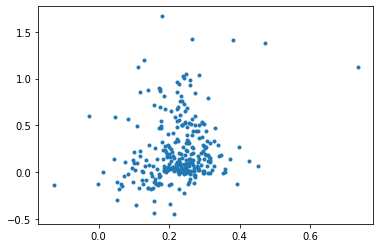

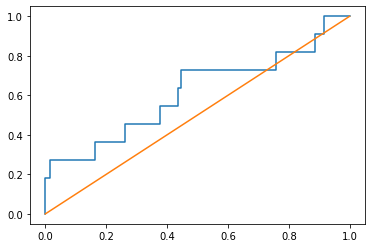

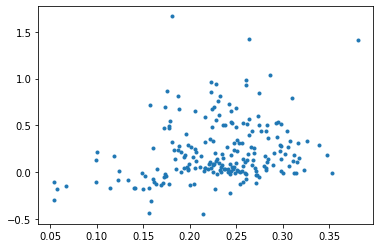

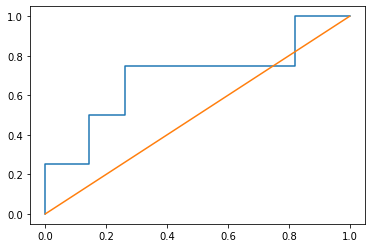

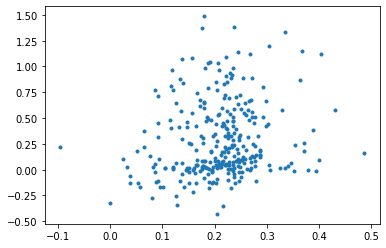

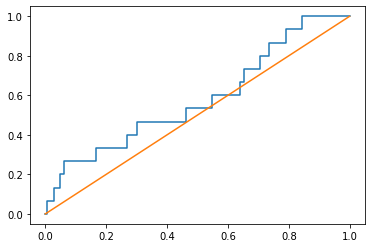

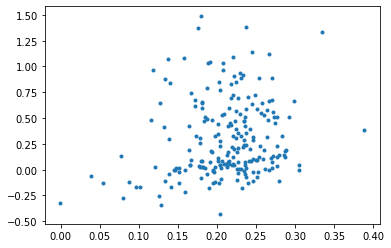

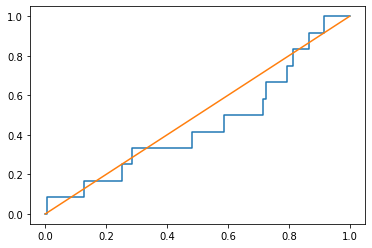

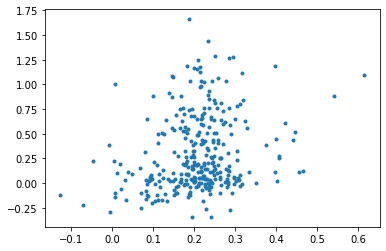

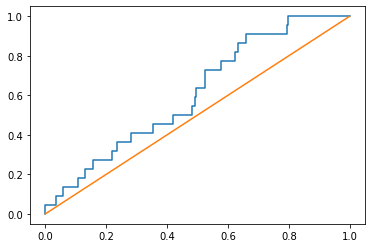

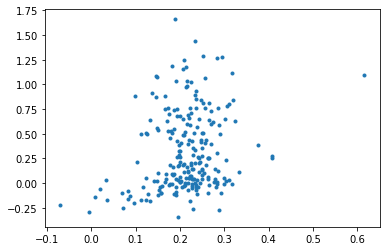

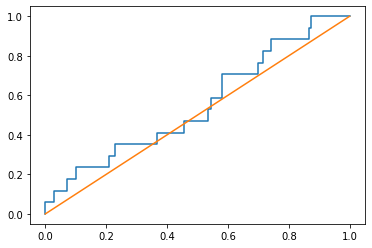

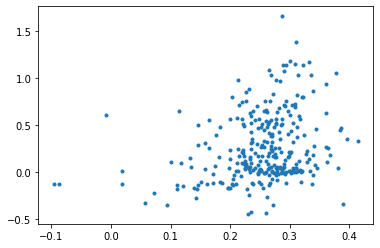

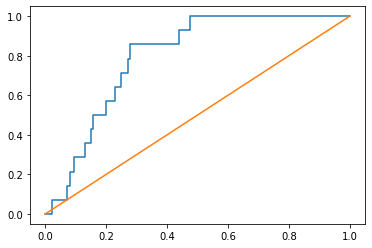

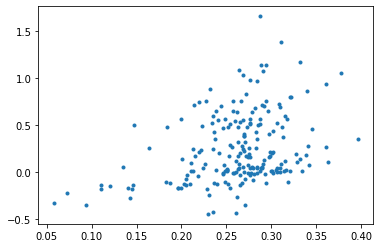

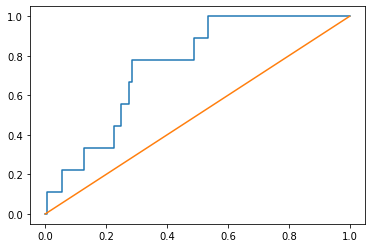

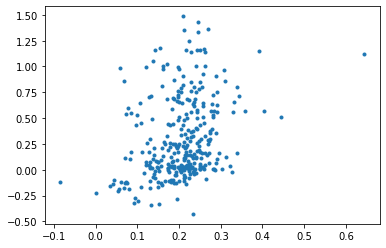

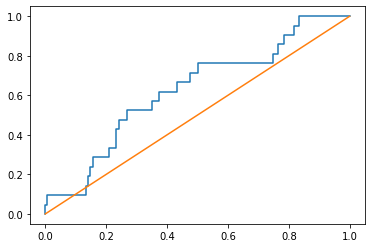

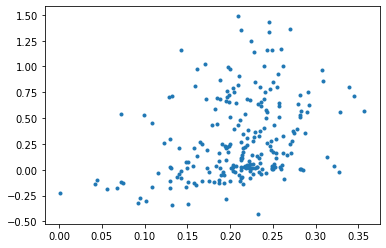

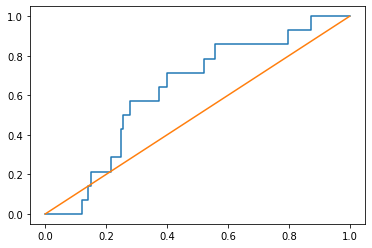

In [127]:
for i in range(5):
    optimal_model = dense_regression_model(input_dim = 278)
    optimal_epoch = optimal_epochs_interactome_only[i]
    weights_fname = 'Model_checkpoints/interactome_only/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_model.load_weights(weights_fname)
    all_corrs_interactome_only[i], all_aucs_interactome_only[i], all_ns_interactome_only[i], good_corrs_interactome_only[i], good_aucs_interactome_only[i], good_ns_interactome_only[i] = get_performance(optimal_model.predict(np.array(all_cv_tests[i][1])),
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)
    

In [128]:
print(np.mean(all_corrs_interactome_only))
print(np.mean(all_aucs_interactome_only))

print(np.mean(good_corrs_interactome_only))
print(np.mean(good_aucs_interactome_only))

print(all_aucs_interactome_only)
print(good_aucs_interactome_only)

0.23541962228134067
0.6455066654678407
0.2682598418158407
0.6159451497281112
[0.6129961587708067, 0.5829787234042554, 0.6089341692789969, 0.7968426501035197, 0.6257816257816258]
[0.6940476190476191, 0.45279146141215104, 0.5532212885154062, 0.75, 0.6296653796653797]


# Normalized expression

In [129]:
cv_models_normalized_expression = [dense_regression_model() for i in range(5)]


In [131]:
for i in [0,1,2,3,4]:
    try:
        os.makedirs('Model_checkpoints/norm_expression/fold_'+str(i))
    except:
        pass
    checkpoint_path = 'Model_checkpoints/norm_expression/fold_'+str(i)+'/saved-model-{epoch:02d}.hdf5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=False,
        period = 5
    )
    train_x = get_normalized_2d_list(all_cv_trains[i][0])
    cv_trains = all_cv_trains[i]
    cv_models_normalized_expression[i].fit(np.array(train_x), cv_trains[6],
                     batch_size = 64, epochs = 150,
                     sample_weight = np.array(cv_trains[7]),
                     shuffle = True, callbacks = [model_checkpoint_callback])

5
2005
4005
6005
8005
10005
12005
14005
16005
18005
20005
Epoch 1/150
21364/21364 [==============================] - 12s 544us/step - loss: 0.0121
Epoch 2/150
21364/21364 [==============================] - 7s 313us/step - loss: 0.0058
Epoch 3/150
21364/21364 [==============================] - 7s 314us/step - loss: 0.0054
Epoch 4/150
21364/21364 [==============================] - 7s 326us/step - loss: 0.0052
Epoch 5/150
21364/21364 [==============================] - 7s 304us/step - loss: 0.0051
Epoch 6/150
21364/21364 [==============================] - 7s 318us/step - loss: 0.0049
Epoch 7/150
21364/21364 [==============================] - 7s 306us/step - loss: 0.0047
Epoch 8/150
21364/21364 [==============================] - 6s 304us/step - loss: 0.0048
Epoch 9/150
21364/21364 [==============================] - 7s 305us/step - loss: 0.0044
Epoch 10/150
21364/21364 [==============================] - 7s 312us/step - loss: 0.0042
Epoch 11/150
21364/21364 [==============================] - 

21364/21364 [==============================] - 7s 335us/step - loss: 5.9663e-04
Epoch 92/150
21364/21364 [==============================] - 8s 395us/step - loss: 6.1087e-04
Epoch 93/150
21364/21364 [==============================] - 8s 394us/step - loss: 6.1559e-04
Epoch 94/150
21364/21364 [==============================] - 8s 376us/step - loss: 6.4083e-04
Epoch 95/150
21364/21364 [==============================] - 8s 370us/step - loss: 6.5262e-04
Epoch 96/150
21364/21364 [==============================] - 10s 451us/step - loss: 6.0364e-04
Epoch 97/150
21364/21364 [==============================] - 9s 420us/step - loss: 6.1833e-04
Epoch 98/150
21364/21364 [==============================] - 7s 347us/step - loss: 5.6812e-04
Epoch 99/150
21364/21364 [==============================] - 7s 337us/step - loss: 5.9151e-04
Epoch 100/150
21364/21364 [==============================] - 7s 322us/step - loss: 5.6154e-04
Epoch 101/150
21364/21364 [==============================] - 7s 326us/step - loss

21135/21135 [==============================] - 7s 339us/step - loss: 5.8310e-04
Epoch 119/150
21135/21135 [==============================] - 7s 335us/step - loss: 5.5942e-04
Epoch 120/150
21135/21135 [==============================] - 7s 336us/step - loss: 5.6541e-04
Epoch 121/150
21135/21135 [==============================] - 7s 347us/step - loss: 5.2414e-04
Epoch 122/150
21135/21135 [==============================] - 7s 324us/step - loss: 5.7895e-04
Epoch 123/150
21135/21135 [==============================] - 7s 315us/step - loss: 5.7768e-04
Epoch 124/150
21135/21135 [==============================] - 6s 303us/step - loss: 5.6304e-04
Epoch 125/150
21135/21135 [==============================] - 7s 309us/step - loss: 5.5245e-04
Epoch 126/150
21135/21135 [==============================] - 7s 318us/step - loss: 5.7708e-04
Epoch 127/150
21135/21135 [==============================] - 6s 302us/step - loss: 5.2790e-04
Epoch 128/150
21135/21135 [==============================] - 6s 301us/step

20927/20927 [==============================] - 6s 300us/step - loss: 5.7902e-04
Epoch 146/150
20927/20927 [==============================] - 7s 321us/step - loss: 5.7848e-04
Epoch 147/150
20927/20927 [==============================] - 6s 304us/step - loss: 5.9025e-04
Epoch 148/150
20927/20927 [==============================] - 6s 302us/step - loss: 5.8521e-04
Epoch 149/150
20927/20927 [==============================] - 6s 298us/step - loss: 5.5662e-04
Epoch 150/150
20927/20927 [==============================] - 6s 294us/step - loss: 5.4897e-04
5
2005
4005
6005
8005
10005
12005
14005
16005
18005
20005
Epoch 1/150
21905/21905 [==============================] - 14s 622us/step - loss: 0.0127
Epoch 2/150
21905/21905 [==============================] - 6s 270us/step - loss: 0.0054
Epoch 3/150
21905/21905 [==============================] - 6s 271us/step - loss: 0.0052
Epoch 4/150
21905/21905 [==============================] - 6s 264us/step - loss: 0.0052
Epoch 5/150
21905/21905 [==============

20626/20626 [==============================] - 7s 331us/step - loss: 0.0025
Epoch 23/150
20626/20626 [==============================] - 7s 330us/step - loss: 0.0022
Epoch 24/150
20626/20626 [==============================] - 6s 312us/step - loss: 0.0022
Epoch 25/150
20626/20626 [==============================] - 6s 306us/step - loss: 0.0023
Epoch 26/150
20626/20626 [==============================] - 7s 328us/step - loss: 0.0025
Epoch 27/150
20626/20626 [==============================] - 7s 321us/step - loss: 0.0020
Epoch 28/150
20626/20626 [==============================] - 6s 308us/step - loss: 0.0020
Epoch 29/150
20626/20626 [==============================] - 7s 332us/step - loss: 0.0019
Epoch 30/150
20626/20626 [==============================] - 6s 312us/step - loss: 0.0019
Epoch 31/150
20626/20626 [==============================] - 7s 318us/step - loss: 0.0019
Epoch 32/150
20626/20626 [==============================] - 6s 309us/step - loss: 0.0019
Epoch 33/150
20626/20626 [========

In [132]:
optimal_epochs_norm_expression = [_ for i in range(5)]

In [133]:
for i in range(5):
    epochs = []
    corrs = []
    model_to_optimize = dense_regression_model()
    weights_path = 'Model_checkpoints/norm_expression/fold_'+str(i)
    model_weights = os.listdir(weights_path)
#     print(model_weights)
    val_x = get_normalized_2d_list(all_cv_vals[i][0])
    for weight_fname in model_weights:
        if weight_fname[0:5] == 'saved':
#             print(weight_fname)
            model_to_optimize.load_weights(weights_path + '/' + weight_fname)
            n_epochs = int(weight_fname.split('.')[0].split('-')[2])
            epochs.append(n_epochs)
            corrs.append(get_corr_only(model_to_optimize.predict(np.array(val_x)),
                                         all_cv_vals[i][6], ref_pert_df, good_cutoff = 4.5))
    print(max(corrs))
    optimal_epoch = epochs[np.argmax(corrs)]
    print(optimal_epoch)
    optimal_epochs_norm_expression[i] = optimal_epoch

5
2005
0.5141923270693112
105
5
2005
0.3405389364114108
105
5
2005
0.3648671010666627
95
5
2005
0.3605255713126854
40
5
2005
0.5062421195793839
50


In [134]:
all_aucs_norm_expression = [_ for i in range(5)]
all_corrs_norm_expression = [_ for i in range(5)]
all_ns_norm_expression = [_ for i in range(5)]
good_aucs_norm_expression = [_ for i in range(5)]
good_corrs_norm_expression = [_ for i in range(5)]
good_ns_norm_expression = [_ for i in range(5)]

5
2005
4005
6005
Using all perturbagens from test set:
Pearson rho:  0.28297516178707244
AUC:  0.721830985915493
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.39139019633831723
AUC:  0.9130952380952381
n:  214


5
2005
4005
6005
Using all perturbagens from test set:
Pearson rho:  0.2797931787075269
AUC:  0.6257683215130024
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3058665267535101
AUC:  0.5931855500821017
n:  215


5
2005
4005
6005
Using all perturbagens from test set:
Pearson rho:  0.2592460540643144
AUC:  0.6384012539184953
n:  312
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.2575574647011339
AUC:  0.5630252100840336
n:  227


5
2005
4005
6005
Using all perturbagens from test set:
Pearson rho:  0.34602068027013017
AUC:  0.7261904761904762
n:  290
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3394567935427509
AUC:  0.6746031746031746
n:  205


5
2005
400

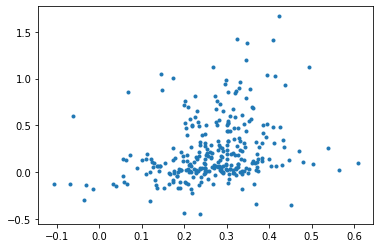

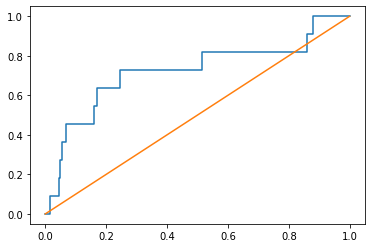

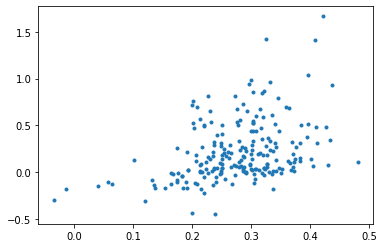

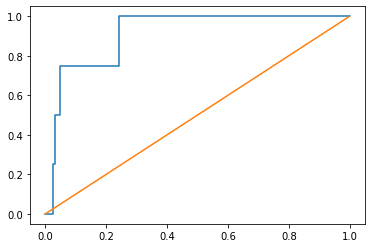

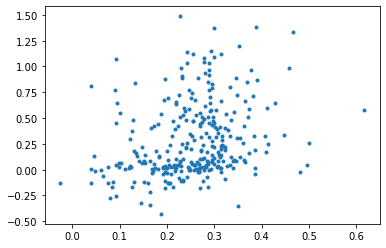

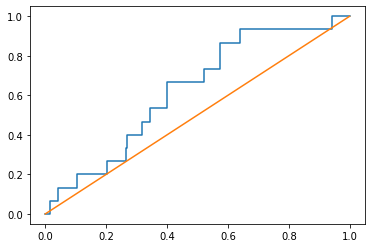

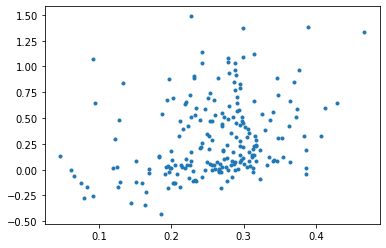

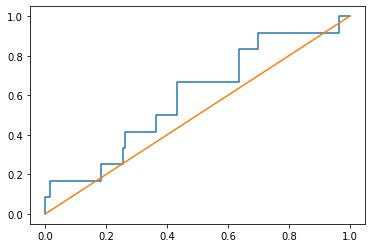

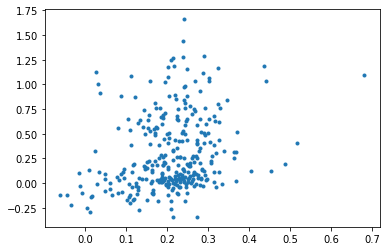

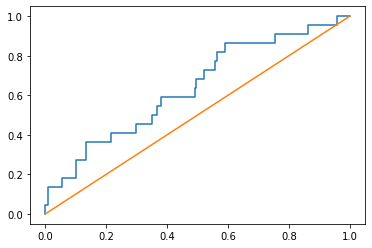

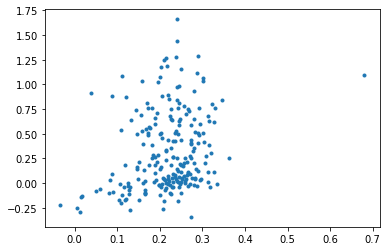

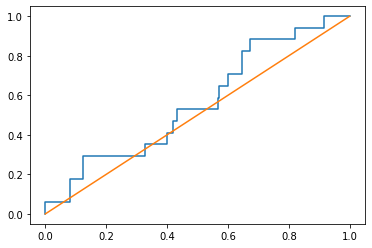

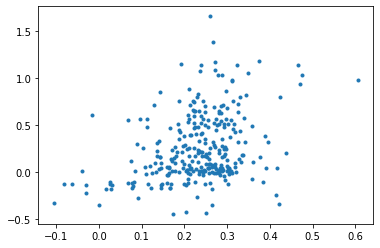

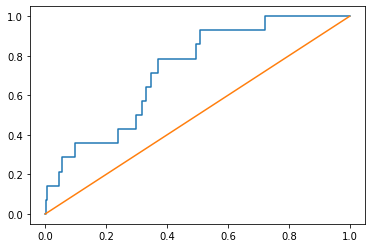

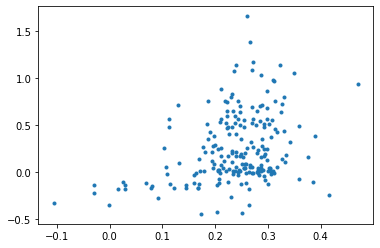

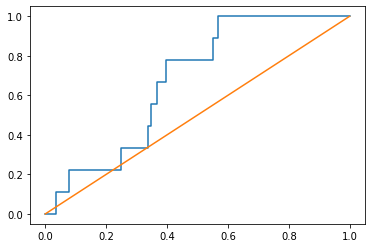

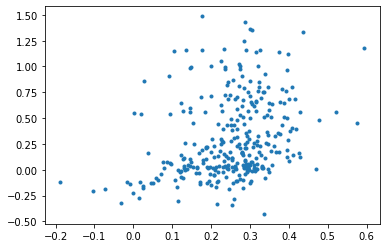

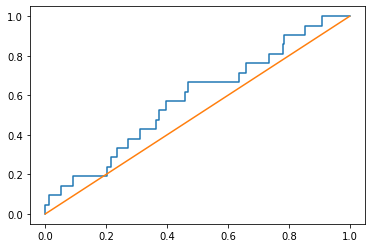

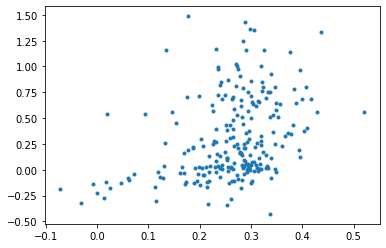

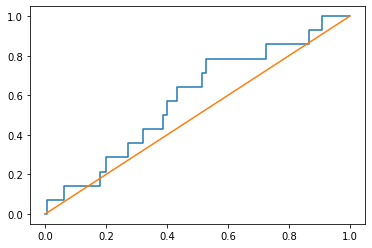

In [137]:
for i in range(5):
    optimal_model = dense_regression_model()
    optimal_epoch = optimal_epochs_norm_expression[i]
    test_x = get_normalized_2d_list(all_cv_tests[i][0])
    weights_fname = 'Model_checkpoints/norm_expression/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_model.load_weights(weights_fname)
    all_corrs_norm_expression[i], all_aucs_norm_expression[i], all_ns_norm_expression[i], good_corrs_norm_expression[i], good_aucs_norm_expression[i], good_ns_norm_expression[i] = get_performance(optimal_model.predict(np.array(test_x)),
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)
    

In [138]:
print(np.mean(all_corrs_norm_expression))
print(np.mean(all_aucs_norm_expression))

print(np.mean(good_corrs_norm_expression))
print(np.mean(good_aucs_norm_expression))

print(all_aucs_norm_expression)
print(good_aucs_norm_expression)

0.29328179297560986
0.6585517236210094
0.3271116017909333
0.6659633017543768
[0.721830985915493, 0.6257683215130024, 0.6384012539184953, 0.7261904761904762, 0.5805675805675805]
[0.9130952380952381, 0.5931855500821017, 0.5630252100840336, 0.6746031746031746, 0.5859073359073359]


# "Ensemble" model: average predictions for gexp only and the full model

In [139]:
optimal_epochs

[70, 45, 115, 60, 150]

In [140]:
optimal_epochs_exp_only

[35, 65, 35, 65, 145]

In [144]:
all_aucs_ensemble = [_ for i in range(5)]
all_corrs_ensemble = [_ for i in range(5)]
all_ns_ensemble = [_ for i in range(5)]
good_aucs_ensemble = [_ for i in range(5)]
good_corrs_ensemble = [_ for i in range(5)]
good_ns_ensemble = [_ for i in range(5)]

Using all perturbagens from test set:
Pearson rho:  0.29128979399901905
AUC:  0.7071062740076823
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3650933340472676
AUC:  0.8654761904761904
n:  214


Using all perturbagens from test set:
Pearson rho:  0.3089661006219623
AUC:  0.5905437352245863
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.39332648475274007
AUC:  0.6301313628899835
n:  215


Using all perturbagens from test set:
Pearson rho:  0.3025207852649685
AUC:  0.6974921630094044
n:  312
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3225904312100329
AUC:  0.6280112044817927
n:  227


Using all perturbagens from test set:
Pearson rho:  0.3620272192134746
AUC:  0.7505175983436854
n:  290
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.34370595020426337
AUC:  0.6326530612244898
n:  205


Using all perturbagens from test set:
Pearson rho:  0.36590642986983046
AUC: 

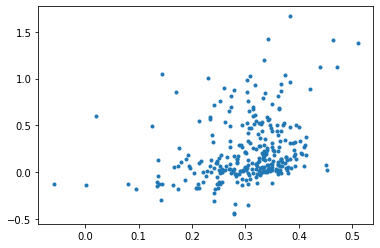

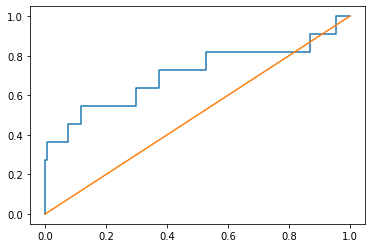

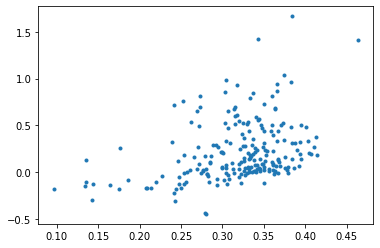

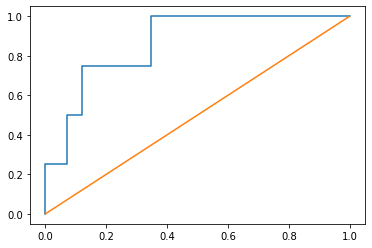

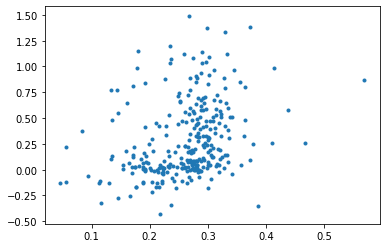

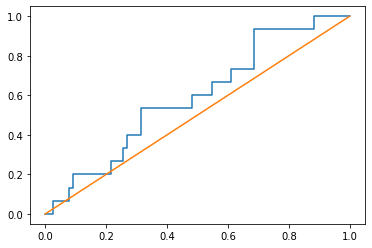

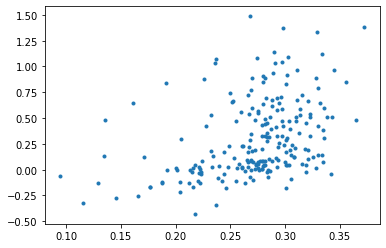

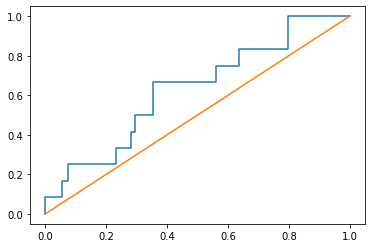

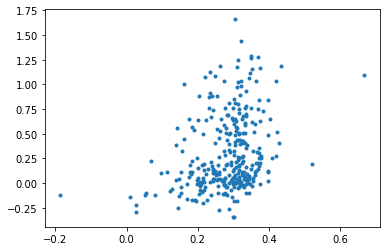

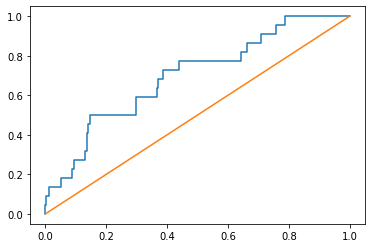

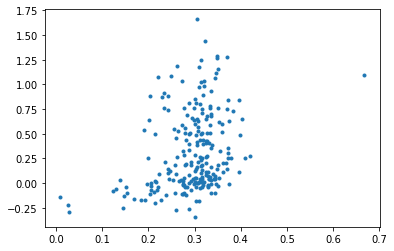

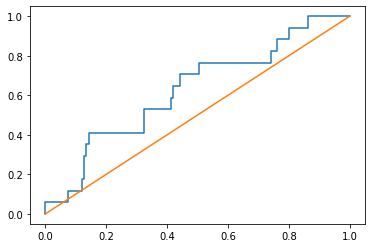

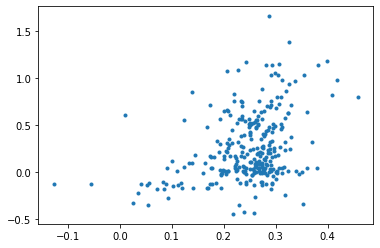

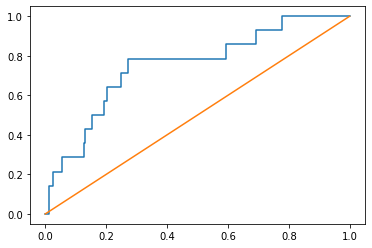

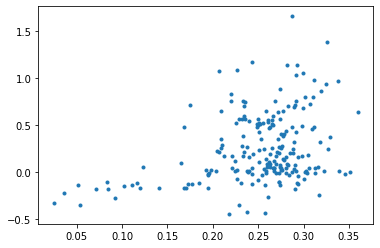

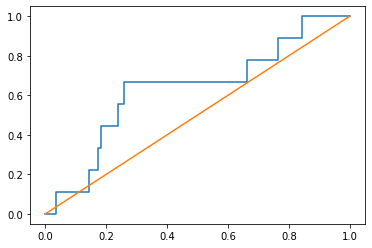

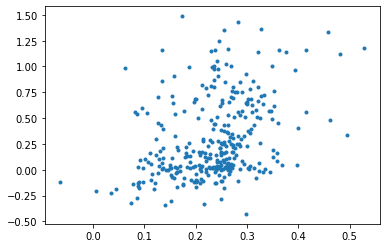

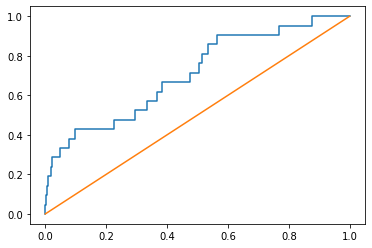

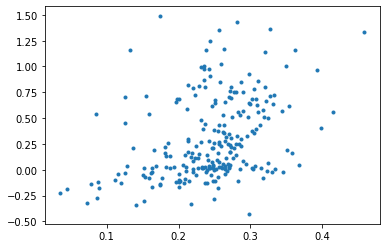

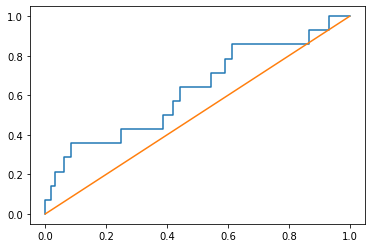

In [145]:
for i in range(5):
    # Expression only model
    optimal_exp_only_model = dense_regression_model()
    optimal_epoch = optimal_epochs_exp_only[i]
    weights_fname = 'Model_checkpoints/expr_only/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_exp_only_model.load_weights(weights_fname)
    exp_only_predictions = optimal_exp_only_model.predict(np.array(all_cv_tests[i][0]))
    
    optimal_full_model = all_dense_model(use_gexp = True, use_gexp_comp = True, use_cos = False, gexp_input_dim = 12328)
    optimal_epoch = optimal_epochs[i]
    weights_fname = 'Model_checkpoints/cov2_comp/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_full_model.load_weights(weights_fname)
    full_predictions = optimal_full_model.predict([np.array(all_cv_tests[i][0]),
                                              np.array(all_cv_tests[i][4]),
                                              np.array(all_cv_tests[i][5])])
    
    averaged_predictions = [(exp_only_predictions[k]+full_predictions[k])/2 for k in range(len(full_predictions))]
    
    all_corrs_ensemble[i], all_aucs_ensemble[i], all_ns_ensemble[i], good_corrs_ensemble[i], good_aucs_ensemble[i], good_ns_ensemble[i] = get_performance(averaged_predictions,
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)
    

In [146]:
print(np.mean(all_corrs_ensemble))
print(np.mean(all_aucs_ensemble))

print(np.mean(good_corrs_ensemble))
print(np.mean(good_aucs_ensemble))

print(all_aucs_ensemble)
print(good_aucs_ensemble)

0.32614206579385097
0.6907384957236132
0.3579440346688958
0.6764152389753665
[0.7071062740076823, 0.5905437352245863, 0.6974921630094044, 0.7505175983436854, 0.708032708032708]
[0.8654761904761904, 0.6301313628899835, 0.6280112044817927, 0.6326530612244898, 0.6258043758043759]


# Compare the drugs predicted well to the drugs predicted badly

In [156]:
def get_performance(predictions, y_vals, reference_df, good_cutoff = 4.5, active_cutoff = 1):
    all_corr, all_auc, all_n = get_performance_given_cutoff(predictions, y_vals, reference_df, 0.5, active_cutoff)
    return all_corr, all_auc, all_n, good_corr, good_auc, good_n

def get_performance_given_cutoff(predictions, y_vals, reference_df, n_measurements_cutoff, active_cutoff):
    predictions = [pred for pred in predictions]
    y_vals = [val for val in y_vals]
#     print('Un-averaged pearson rho: ',np.corrcoef(np.array(predictions).T, y_vals)[0][1])
    tau,pval = kendalltau(predictions, y_vals)
#     print('Un-averaged kendall tau: ', tau)
#     plt.figure()
#     plt.plot(predictions, y_vals, '.')
    averaged_predictions, actual_y_vals = average_predictions_over_measurements(predictions, y_vals, reference_df,
                                                                                n_measurements_cutoff = n_measurements_cutoff)
#     print('Averaged pearson rho: ',np.corrcoef(np.array(averaged_predictions).T, actual_y_vals)[0][1])
    tau,pval = kendalltau(averaged_predictions, actual_y_vals)
#     print('Averaged kendall tau: ', tau)
    plt.figure()
    plt.plot(averaged_predictions, actual_y_vals, '.')
    actual_class = [1.0*(val>active_cutoff) for val in actual_y_vals]
#     print(actual_class)
#     print(averaged_predictions)
    fpr, tpr, thresholds = roc_curve(actual_class, averaged_predictions)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1])
#     print('AUC: ',roc_auc_score(actual_class, averaged_predictions))
    return np.corrcoef(np.array(averaged_predictions).T, actual_y_vals)[0][1], roc_auc_score(actual_class, averaged_predictions), len(actual_y_vals)
    
def get_averaged_predictions(predictions, y_vals, reference_df, good_cutoff = 4.5):
    all_preds, all_actual_y = average_predictions_over_measurements(predictions, y_vals, reference_df)
    good_preds, good_actual_y = average_predictions_over_measurements(predictions, y_vals, reference_df, n_measurements_cutoff = good_cutoff)
    return all_preds, all_actual_y, good_preds, good_actual_y
    
    
def average_predictions_over_measurements(predictions, y_vals, reference_df, n_measurements_cutoff = 0.5):
    sorted_predictions = [[] for i in range(len(reference_df))]
    averaged_predictions = []
#     actual_y_vals = reference_df.Inh_index
    actual_y_vals = []
    for i, val in enumerate(y_vals):
        index = reference_df.index[reference_df.Inh_index == val].tolist()[0]
#         if len(reference_df.index[reference_df.Inh_index == val].tolist())>1:
#             print('ERROR with val ',val)
#             for idx in reference_df.index[reference_df.Inh_index == val].tolist():
#                 print(idx)
#             return 0
        sorted_predictions[index].append(predictions[i])
    for i, pred_list in enumerate(sorted_predictions):
        if len(pred_list)>n_measurements_cutoff:
            averaged_predictions.append(np.mean(pred_list))
            actual_y_vals.append(reference_df.Inh_index[i])
#     averaged_predictions = [np.mean(sort) for sort in sorted_predictions]
#     print('SLKFJASL;KDFJSADL;KFJ\n\n')
#     print(len(averaged_predictions))
#     print(len(actual_y_vals))
#     print('\n\n\n')
    return averaged_predictions, actual_y_vals

In [157]:
all_averaged_predictions = []
all_test_y_vals = []
good_averaged_predictions = []
good_test_y_vals = []

In [158]:
for i in range(5):
    # Expression only model
    optimal_exp_only_model = dense_regression_model()
    optimal_epoch = optimal_epochs_exp_only[i]
    weights_fname = 'Model_checkpoints/expr_only/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_exp_only_model.load_weights(weights_fname)
    exp_only_predictions = optimal_exp_only_model.predict(np.array(all_cv_tests[i][0]))
    
    optimal_full_model = all_dense_model(use_gexp = True, use_gexp_comp = True, use_cos = False, gexp_input_dim = 12328)
    optimal_epoch = optimal_epochs[i]
    weights_fname = 'Model_checkpoints/cov2_comp/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_full_model.load_weights(weights_fname)
    full_predictions = optimal_full_model.predict([np.array(all_cv_tests[i][0]),
                                              np.array(all_cv_tests[i][4]),
                                              np.array(all_cv_tests[i][5])])
    
    averaged_predictions = [(exp_only_predictions[k]+full_predictions[k])/2 for k in range(len(full_predictions))]
    aap, atyv, gap, gtyv = get_averaged_predictions(averaged_predictions, all_cv_tests[i][6], ref_pert_df)
    all_averaged_predictions += aap
    all_test_y_vals += atyv
    good_averaged_predictions += gap
    good_test_y_vals += gtyv
    print(i)
#     all_corrs_ensemble[i], all_aucs_ensemble[i], all_ns_ensemble[i], good_corrs_ensemble[i], good_aucs_ensemble[i], good_ns_ensemble[i] = get_performance(averaged_predictions,
#                     all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)

0
1
2
3
4


In [163]:
all_averaged_predictions[0:10]

[0.30484453,
 0.2538584,
 0.342644,
 0.20313609,
 0.36527222,
 0.36196804,
 0.3647598,
 0.3149993,
 0.33400235,
 0.2507611]

In [170]:
for i,pred in enumerate(good_averaged_predictions):
    if pred > 0.45:
        print(good_test_y_vals[i])

1.4110055030000002
1.096532563
1.338431048


In [ ]:
# The 1.411 is: quinidine
# The 1.0965 is: exemestane
# The 1.338 is: atracurium

In [164]:
np.corrcoef(all_averaged_predictions, all_test_y_vals)

array([[1.        , 0.29721282],
       [0.29721282, 1.        ]])

In [165]:
np.corrcoef(good_averaged_predictions, good_test_y_vals)

array([[1.        , 0.30626242],
       [0.30626242, 1.        ]])

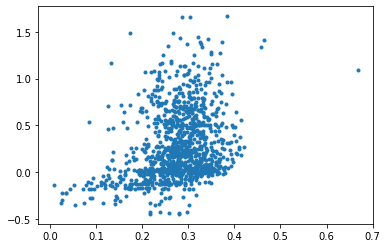

In [168]:
plt.plot(good_averaged_predictions, good_test_y_vals,'.')

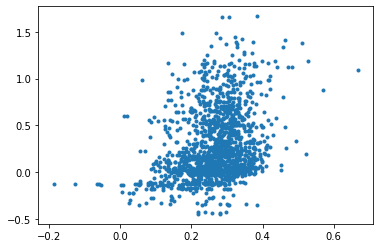

In [167]:
plt.plot(all_averaged_predictions, all_test_y_vals,'.')

# Make predictions using the ensemble model

# Normalize expression and include cell type and comparison to cov

# Pickle test and validation sets

In [121]:
import pickle
with open('Data_for_ML/Feature_variables/all_x_tests.pickle', 'wb') as f:
    pickle.dump(all_cv_tests, f)

In [171]:
with open('Data_for_ML/Feature_variables/all_x_vals.pickle', 'wb') as f:
    pickle.dump(all_cv_vals, f)